# CW + Diversity Regularization on Udacity Self-Driving Car Data

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder, ImageFolder

import pickle
import datetime
import glob
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from matplotlib.pyplot import imread

# custom code imports
# from models import *
from cw_div import *
from neuron_coverage import *
from inception_score import *
from fid_score import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!')
    device = torch.device("cuda")
else:
    print('CUDA is not available...')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA is available!


# Load Data with Custom Loader
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [2]:
class car_loader(Dataset):

    def __init__(self, target_csv_file, img_dir, transform=None):
        """
        Args:
            target_csv_file (string) : Path to the csv file with steering angles.
            img_dir (string)         : Directory with all the images.
        """
        self.steering_angles = torch.tensor(pd.read_csv(target_csv_file)['steering_angle'].values)
        self.root_dir = img_dir
        self.img_paths = glob.glob(os.path.join(img_dir) + '\\*.jpg')
        self.transform = transform

    def __len__(self):
        return len(self.steering_angles)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # images
        paths = self.img_paths[idx]
        images = imread(paths)
        
        if self.transform:
            images = self.transform(images)
        
        # angles
        angles = self.steering_angles[idx]
        
        sample = (images, angles)

        return sample

In [23]:
data_dir = r'C:\data\udacity_self_driving_car'
targets_file = 'targets.csv'
batch_size = 32

dataset = car_loader(target_csv_file=os.path.join(data_dir, targets_file),
                    img_dir=os.path.join(data_dir, 'data'),
                    transform=transforms.Compose([transforms.ToPILImage(),
                                                  transforms.Resize((100,100)),
                                                  transforms.ToTensor()]))

test_loader = DataLoader(dataset, batch_size=batch_size)

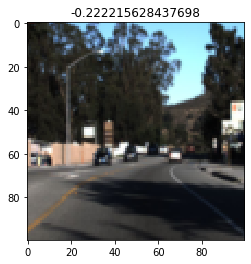

In [36]:
# confirm that the data loader works correctly
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.to(device)

np_data = inputs.clone().permute(0,2,3,1).cpu().detach().numpy()
np_targets = targets.clone().cpu().detach().numpy()

plt.imshow(np.squeeze(np_data[31])) 
plt.title(np_targets[31])
plt.show()

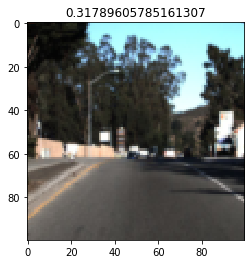

In [25]:
plt.imshow(np.squeeze(np_data[3])) 
plt.title(np_targets[3])
plt.show()

# Model

Training this model would be prohibitively time consuming so I'm going to recreate the model from DeepXplore and load their pretrained weights. This is a little tricky since everything was originally done in keras and the weights are stored in hdf5...

In [ ]:
# # DeepXplore Driving Model originally done in Keras
# def Dave_orig(input_tensor=None, load_weights=False):  # original dave
#     if input_tensor is None:
#         input_tensor = Input(shape=(100, 100, 3))
#     x = Convolution2D(24, (5, 5), padding='valid', activation='relu', strides=(2, 2), name='block1_conv1')(input_tensor)
#     x = Convolution2D(36, (5, 5), padding='valid', activation='relu', strides=(2, 2), name='block1_conv2')(x)
#     x = Convolution2D(48, (5, 5), padding='valid', activation='relu', strides=(2, 2), name='block1_conv3')(x)
#     x = Convolution2D(64, (3, 3), padding='valid', activation='relu', strides=(1, 1), name='block1_conv4')(x)
#     x = Convolution2D(64, (3, 3), padding='valid', activation='relu', strides=(1, 1), name='block1_conv5')(x)
#     x = Flatten(name='flatten')(x)
#     x = Dense(1164, activation='relu', name='fc1')(x)
#     x = Dense(100, activation='relu', name='fc2')(x)
#     x = Dense(50, activation='relu', name='fc3')(x)
#     x = Dense(10, activation='relu', name='fc4')(x)
#     x = Dense(1, name='before_prediction')(x)
#     x = Lambda(atan_layer, output_shape=atan_layer_shape, name='prediction')(x)

#     m = Model(input_tensor, x)
#     if load_weights:
#         m.load_weights('./Model1.h5')

#     # compiling
#     m.compile(loss='mse', optimizer='adadelta')
#     print(bcolors.OKGREEN + 'Model compiled' + bcolors.ENDC)
#     return m

In [27]:
class Dave_orig(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, (5, 5), stride=(2, 2))
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(24, 36, (5, 5), stride=(2, 2))
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(36, 48, (5, 5), stride=(2, 2))
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(48, 64, (3, 3), stride=(1, 1))
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(64, 64, (3, 3), stride=(1, 1))
        self.relu5 = nn.ReLU()
        self.fc1 = nn.Linear(1600, 1164)
        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(1164, 100)
        self.relu7 = nn.ReLU()
        self.fc3 = nn.Linear(100, 50)
        self.relu8 = nn.ReLU()
        self.fc4 = nn.Linear(50, 10)
        self.relu9 = nn.ReLU()
        self.before_prediction = nn.Linear(10, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = x.view(-1, 1600)
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.fc2(x)
        x = self.relu7(x)
        x = self.fc3(x)
        x = self.relu8(x)
        x = self.fc4(x)
        x = self.relu9(x)
        x = self.before_prediction(x)
        x = torch.atan(x) * 2
        return x

In [28]:
model = Dave_orig().to(device)

In [29]:
# save a model state_dict to serve as a framework for inserting the extracted data points from the hdf5 file
torch.save(model.state_dict(), 'pretrained_models/driving/Model1.pth')
state_dict = torch.load('pretrained_models/driving/Model1.pth')
# state_dict

### Extract data from HDF5 file (basis of Keras weight parameter saving)

In [30]:
import h5py
filename = r'C:\Users\Fabrice\Documents\GitHub\deepxplore-CS239\Driving\Model1.h5'
f = h5py.File(filename, 'r')

def h5py_dataset_iterator(g, prefix=''):
    for key in g.keys():
        item = g[key]
        path = '{}/{}'.format(prefix, key)
        if isinstance(item, h5py.Dataset): # test for dataset
            yield (path, item)
        elif isinstance(item, h5py.Group): # test for group (go down)
            yield from h5py_dataset_iterator(item, path)

In [31]:
layer_map = {
    '/block1_conv1/block1_conv1/kernel:0' : 'conv1.weight',
    '/block1_conv1/block1_conv1/bias:0'   : 'conv1.bias', 
    '/block1_conv2/block1_conv2/kernel:0' : 'conv2.weight', 
    '/block1_conv2/block1_conv2/bias:0'   : 'conv2.bias', 
    '/block1_conv3/block1_conv3/kernel:0' : 'conv3.weight', 
    '/block1_conv3/block1_conv3/bias:0'   : 'conv3.bias', 
    '/block1_conv4/block1_conv4/kernel:0' : 'conv4.weight', 
    '/block1_conv4/block1_conv4/bias:0'   : 'conv4.bias', 
    '/block1_conv5/block1_conv5/kernel:0' : 'conv5.weight', 
    '/block1_conv5/block1_conv5/bias:0'   : 'conv5.bias', 
    '/fc1/fc1/bias:0'   : 'fc1.bias', 
    '/fc1/fc1/kernel:0' : 'fc1.weight', 
    '/fc2/fc2/bias:0'   : 'fc2.bias', 
    '/fc2/fc2/kernel:0' : 'fc2.weight', 
    '/fc3/fc3/bias:0'   : 'fc3.bias', 
    '/fc3/fc3/kernel:0' : 'fc3.weight', 
    '/fc4/fc4/bias:0'   : 'fc4.bias', 
    '/fc4/fc4/kernel:0' : 'fc4.weight', 
    '/before_prediction/before_prediction/kernel:0' : 'before_prediction.weight', 
    '/before_prediction/before_prediction/bias:0'   : 'before_prediction.bias'
}

In [32]:
for (path, dset) in h5py_dataset_iterator(f):
    key = layer_map[path] 
    params = torch.tensor(dset[:])
    if len(params.size()) == 4:
        params = params.permute(3,2,1,0)
    elif len(params.size()) == 2:
        params = params.permute(1,0)
    else:
        params = torch.tensor(dset[:])
    state_dict[key] = params
    
# state_dict

In [33]:
model.load_state_dict(state_dict) 

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [34]:
inputs.size()

torch.Size([32, 3, 100, 100])

In [35]:
print(model(inputs), targets)

tensor([[0.0807],
        [0.0807],
        [0.0806],
        [0.0803],
        [0.0800],
        [0.0794],
        [0.0794],
        [0.0795],
        [0.0801],
        [0.0806],
        [0.0803],
        [0.0804],
        [0.0802],
        [0.0800],
        [0.0797],
        [0.0792],
        [0.0804],
        [0.0804],
        [0.0810],
        [0.0816],
        [0.0818],
        [0.0820],
        [0.0824],
        [0.0836],
        [0.0841],
        [0.0847],
        [0.0843],
        [0.0833],
        [0.0825],
        [0.0813],
        [0.0822],
        [0.0821]], device='cuda:0', grad_fn=<MulBackward0>) tensor([-0.3737, -0.0654, -0.1607,  0.3179,  0.1965, -0.3414, -0.0240, -0.2538,
         0.3020, -0.3827, -0.0445,  0.2953, -0.1876, -0.2351, -0.3245, -0.2598,
        -0.1360, -0.2464, -0.0042, -0.0717, -0.0109, -0.2905,  0.2808, -0.0073,
         0.0540, -0.0361,  0.0919,  0.3614,  0.0266,  0.1933,  0.1769, -0.2222],
       device='cuda:0', dtype=torch.float64)


### Layer Dict
Required for extracting outputs for diversity regularization. 

In [270]:
layer_dict = get_model_modules(model)
                    
# layer_dict
# layer_dict['conv1-0']

# Attack Time

| Version | Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - | - |
|  Baseline CW | CW |  True | L2 |  L2 |
|  Diversity v1 | CW |  True | L2, Batch Divergence | Instance Divergence |
|  Diversity v2 | CW |  False | L2, Batch Divergence | Instance Divergence |
|  Diversity v3 | Cross Entropy |  False | L2, Batch Divergence | Instance Divergence |
|  Diversity v4 | CW |  True | L2, Batch Divergence | L2 |

In [42]:
# all configurations
targeted=False
confidence=0.0
c_range=(1e-3, 1e10)
search_steps=5
max_steps=1000
abort_early=True
optimizer_lr=5e-4
init_rand=False

mean = (0.485, 0.456, 0.406) # the mean used in inputs normalization
std = (0.229, 0.224, 0.225) # the standard deviation used in inputs normalization
box = (min((0 - m) / s for m, s in zip(mean, std)),
       max((1 - m) / s for m, s in zip(mean, std)))

log_frequency = 100

# diversity specific configurations
regularizer_weight = 1
module = layer_dict['conv1-0']

## Baseline CW

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | L2 | L2 |

In [43]:
# cw_advs = cw_l2_attack(model, inputs, targets, device, targeted, confidence,
#                        c_range, search_steps, max_steps, abort_early, box, 
#                        optimizer_lr, init_rand, log_frequency)

# eval_performance(model, inputs, cw_advs, targets)
# sample_3D_images(model, inputs, cw_advs, targets)

## Diversity Attack v1

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | L2, Batch Divergence | Instance Divergence |

In [44]:
# cw_advs_div1 = cw_div1_attack(model, module, regularizer_weight, inputs, targets, 
#                               device, targeted, confidence, c_range, search_steps, 
#                               max_steps, abort_early, box, optimizer_lr, init_rand, 
#                               log_frequency)

# eval_performance(model, inputs, cw_advs_div1, targets)
# sample_3D_images(model, inputs, cw_advs_div1, targets)

## Diversity Attack v2

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  False | L2, Batch Divergence | Instance Divergence |

In [45]:
# cw_advs_div2 = cw_div2_attack(model, module, regularizer_weight, inputs, targets, 
#                               device, targeted, confidence, c_range, search_steps, 
#                               max_steps, abort_early, box, optimizer_lr, init_rand, 
#                               log_frequency)

# eval_performance(model, inputs, cw_advs_div2, targets)
# sample_3D_images(model, inputs, cw_advs_div2, targets)

## Diversity Attack v3

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| Cross Entropy |  False | L2, Batch Divergence | Instance Divergence |

In [46]:
# cw_advs_div3 = cw_div3_attack(model, module, regularizer_weight, inputs, targets, 
#                               device, targeted, confidence, c_range, search_steps, 
#                               max_steps, abort_early, box, optimizer_lr, init_rand, 
#                               log_frequency)

# eval_performance(model, inputs, cw_advs_div3, targets)
# sample_3D_images(model, inputs, cw_advs_div3, targets)

## Diversity Attack v4

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| CW |  True | L2, Batch Divergence | L2 |

In [47]:
# cw_advs_div4 = cw_div4_attack(model, module, regularizer_weight, inputs, targets, 
#                               device, targeted, confidence, c_range, search_steps, 
#                               max_steps, abort_early, box, optimizer_lr, init_rand, 
#                               log_frequency)

# eval_performance(model, inputs, cw_advs_div4, targets)
# sample_3D_images(model, inputs, cw_advs_div4, targets)

# Evaluation

In [48]:
# n=11
# target_layers = list(layer_dict)[0::n]
# for layer_idx in target_layers:
#     module = layer_dict[layer_idx]
#     print(layer_idx, module)

In [49]:
# n=11
# target_layers = list(layer_dict)[0::n]
# reg_weights = [0, 0.01, 1, 10]
# confidences = [0, 20, 40]
# attack_versions = [cw_div4_attack] # [cw_div1_attack, cw_div2_attack, cw_div3_attack, cw_div4_attack]

# len(target_layers) * len(reg_weights) * len(confidences) * len(attack_versions)

timestamp 2019-08-08 17.02.28.157569 attack cw_div4_attack layer:  conv1-0 regularization_weight:  0 confidence:  0
Step 0
batch [0] batch_loss: 9.885351181030273 cw_loss: 1.0567498207092285 L2_loss: 8.828601837158203 div_reg: 0.0
Perturbed Accuracy: 67/100 (67%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


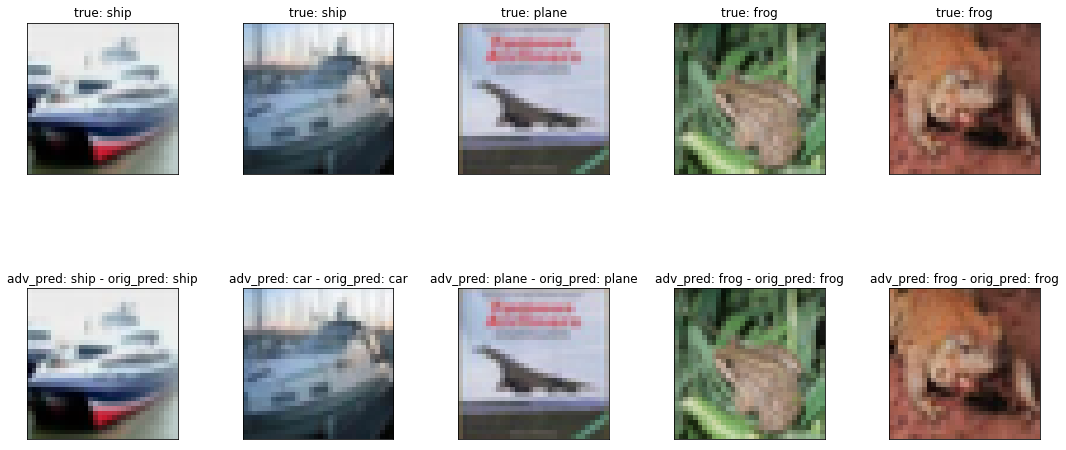

neuron_coverage: 0.9523803263911059
inception_score: 3.1605954064787625
starting calculate_activation_statistics()...



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

starting calculate_activation_statistics()...



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

fid_score_64: 2.8578516116312472e-08
starting calculate_activation_statistics()...



100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:48<00:00,  1.51s/it]

starting calculate_activation_statistics()...



100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:46<00:00,  1.46s/it]

fid_score_2048: 2.976845560132002e-05


PermissionError: [Errno 13] Permission denied: 'assets/results_cifar10.pkl'

In [68]:
results = []
save_file_path = "assets/results_cifar10.pickle"

# attack params
search_steps=1
targeted=False
c_range=(1e-3, 1e10)
max_steps=100
abort_early=True
optimizer_lr=5e-4
init_rand=False
log_frequency = 100

mean = (0.485, 0.456, 0.406) # the mean used in inputs normalization
std = (0.229, 0.224, 0.225) # the standard deviation used in inputs normalization
box = (min((0 - m) / s for m, s in zip(mean, std)),
       max((1 - m) / s for m, s in zip(mean, std)))

n=11
attack_versions = [cw_div4_attack] # [cw_div1_attack, cw_div2_attack, cw_div3_attack, cw_div4_attack]
target_layers = list(layer_dict)[0::n]
reg_weights = [0, 0.01, 1, 10]
confidences = [0, 20, 40]

# neuron coverage params
nc_threshold = 0. # all activations are scaled to (0,1) after relu

# inception score (is) params
is_cuda = True
is_batch_size = 10
is_resize = True
is_splits = 10

# fréchet inception distance score (fid) params
real_path = "C:/temp_imgs/cifar/real/"
fake_path = "C:/temp_imgs/cifar/fake/"
fid_batch_size = 64
fid_cuda = True

if not os.path.exists(save_file_path):
    os.makedirs(save_file_path)

for attack in attack_versions:
    for layer_idx in target_layers:
        module = layer_dict[layer_idx]
        for rw in reg_weights:
            for c in confidences:
                
                timestamp = str(datetime.datetime.now()).replace(':','.')
                
                print('timestamp', timestamp, 
                      'attack', attack.__name__, 
                      'layer: ', layer_idx, 
                      'regularization_weight: ', rw, 
                      'confidence: ', c)
                
                # adversarial attack 
                adversaries = attack(model, module, rw, inputs, targets, device, targeted,
                                     c, c_range, search_steps, max_steps, abort_early, box,
                                     optimizer_lr, init_rand, log_frequency)
               
                # evaluate adversary effectiveness
                pert_acc, orig_acc = eval_performance(model, inputs, adversaries, targets)
                sample_3D_images(model, inputs, adversaries, targets, classes)
                
                pert_acc = pert_acc.item() / 100.
                orig_acc = orig_acc.item() / 100.
                
                # neuron coverage
                covered_neurons, total_neurons, neuron_coverage = eval_nc(model, adversaries, nc_threshold)
                print('neuron_coverage:', neuron_coverage)
                
                # inception score
                preprocessed_advs = preprocess_3D_imgs(adversaries)
                mean_is, std_is = inception_score(preprocessed_advs, is_cuda, is_batch_size, is_resize, is_splits)
                print('inception_score:', mean_is)
                
                # fid score 
                paths = [real_path, fake_path]
                
                # dimensionality = 64
                target_num = 64
                generate_imgs(inputs, real_path, target_num)
                generate_imgs(adversaries, fake_path, target_num)
                fid_score_64 = calculate_fid_given_paths(paths, fid_batch_size, fid_cuda, dims=64)
                print('fid_score_64:', fid_score_64)
                
                # dimensionality = 2048
                target_num = 2048
                generate_imgs(inputs, real_path, target_num)
                generate_imgs(adversaries, fake_path, target_num)
                fid_score_2048 = calculate_fid_given_paths(paths, fid_batch_size, fid_cuda, dims=2048)
                print('fid_score_2048:', fid_score_2048)
                
                out = {'timestamp': timestamp, 
                       'attack': attack.__name__, 
                       'layer': layer_idx, 
                       'regularization_weight': rw, 
                       'confidence': c, 
                       'adversaries': adversaries,
                       'pert_acc':pert_acc, 
                       'orig_acc': orig_acc,
                       'neuron_coverage': neuron_coverage,
                       'inception_score': mean_is,
                       'fid_score_64': fid_score_64,
                       'fid_score_2048': fid_score_2048}
                
                results.append(out)
                
                # save incremental outputs
                pickle.dump(results, open(save_file_path, "wb"))

# Results

In [69]:
# load the results from file
with open('assets/results_cifar10.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [71]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)
target_features = ['attack', 'layer', 'regularization_weight', 'confidence', 'orig_acc', 'pert_acc', 'neuron_coverage', 'inception_score', 'fid_score_64', 'fid_score_2048']
df[target_features] # .to_clipboard(excel=True)

Perturbed Accuracy: 62/100 (62%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


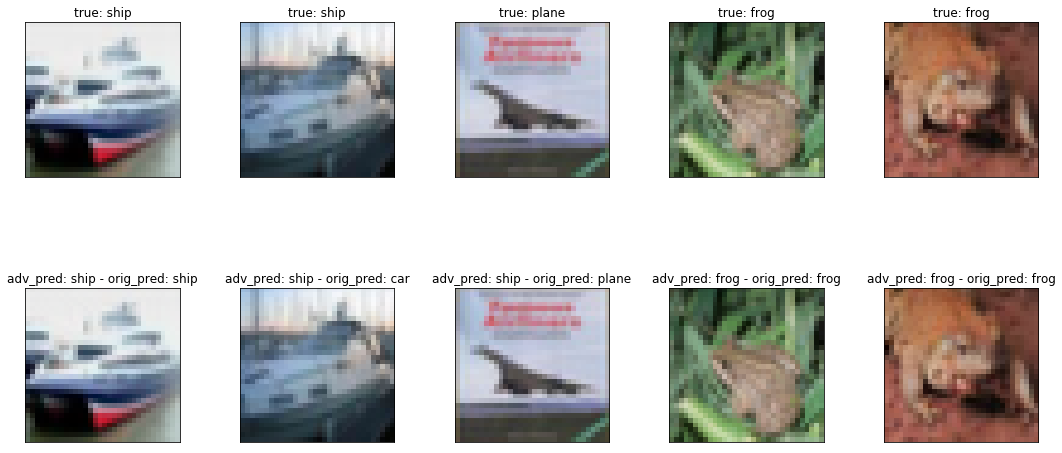

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


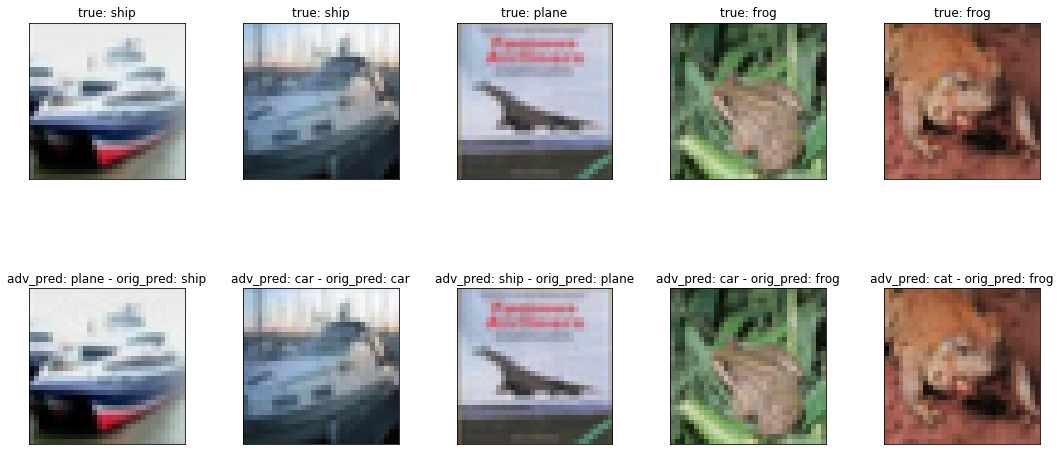

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


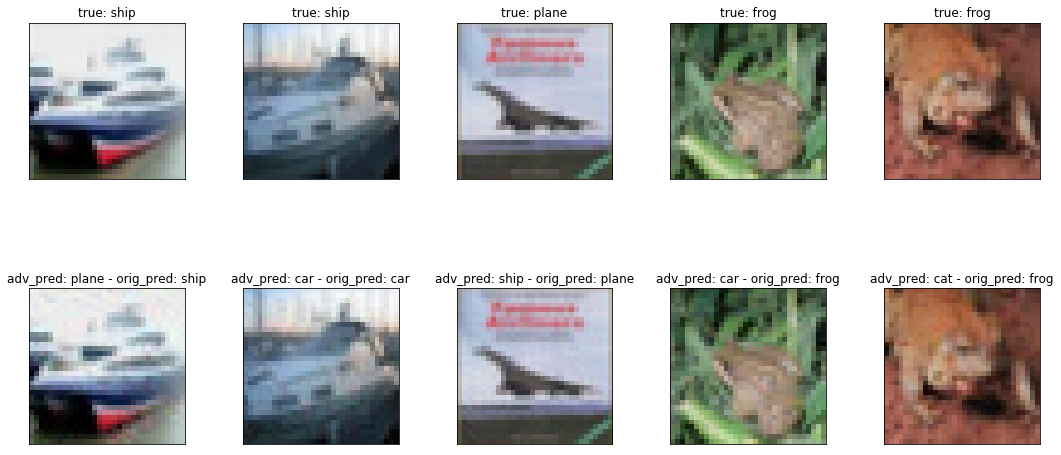

Perturbed Accuracy: 69/100 (69%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


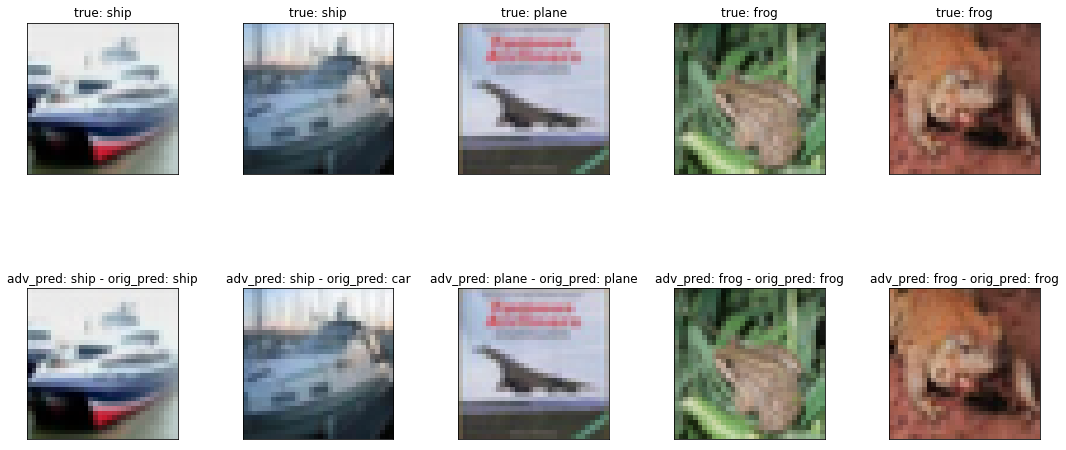

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


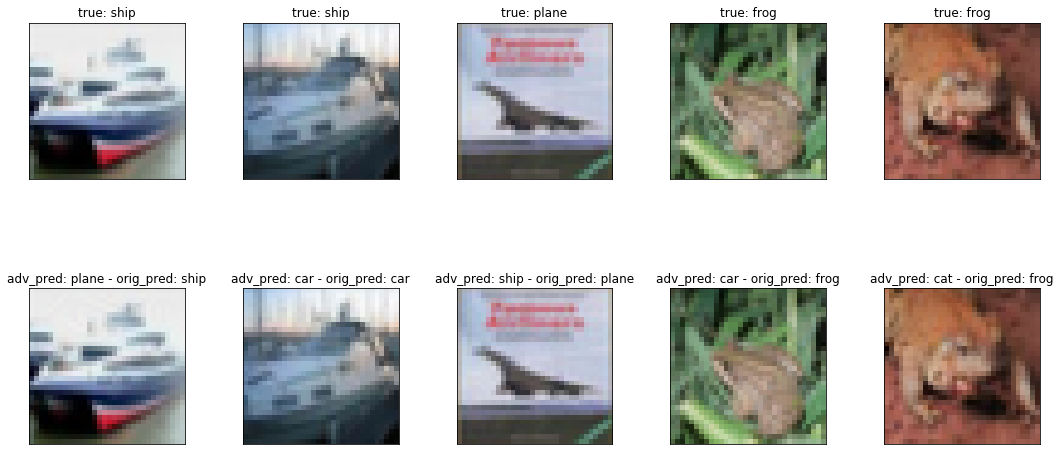

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


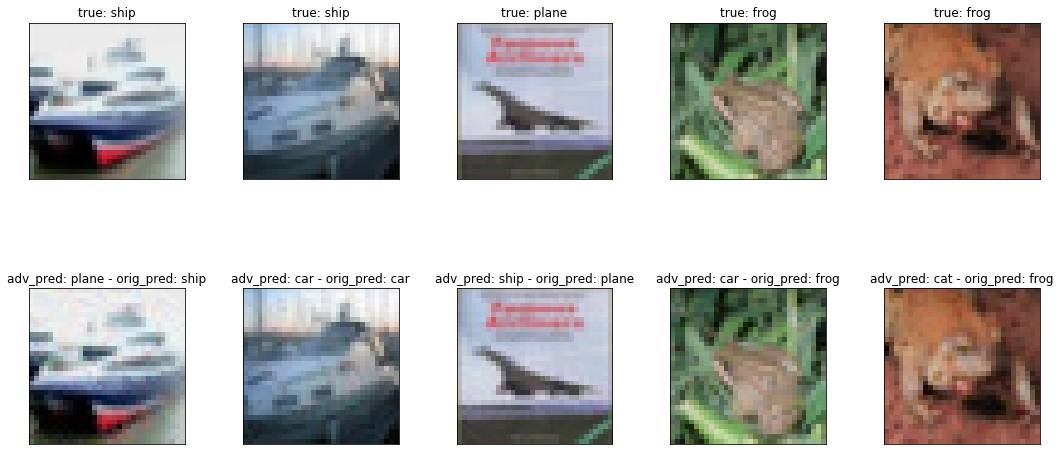

Perturbed Accuracy: 68/100 (68%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


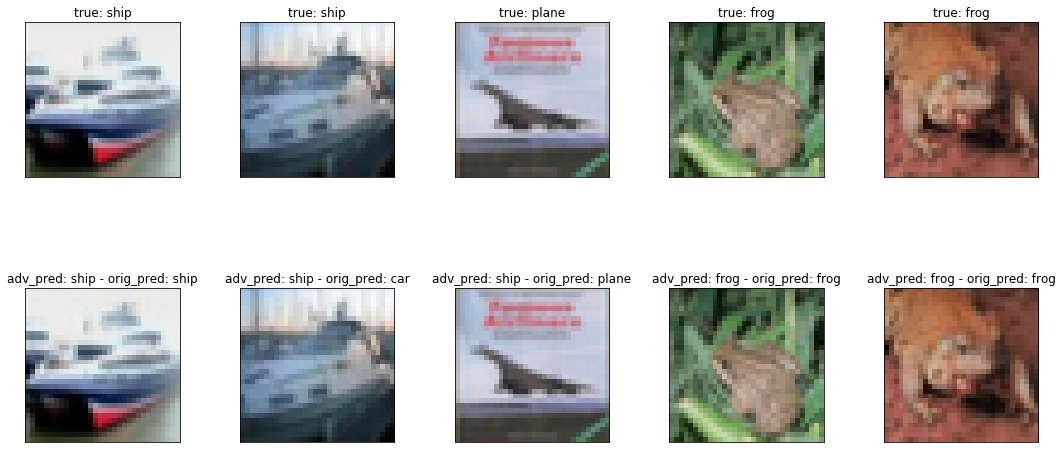

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


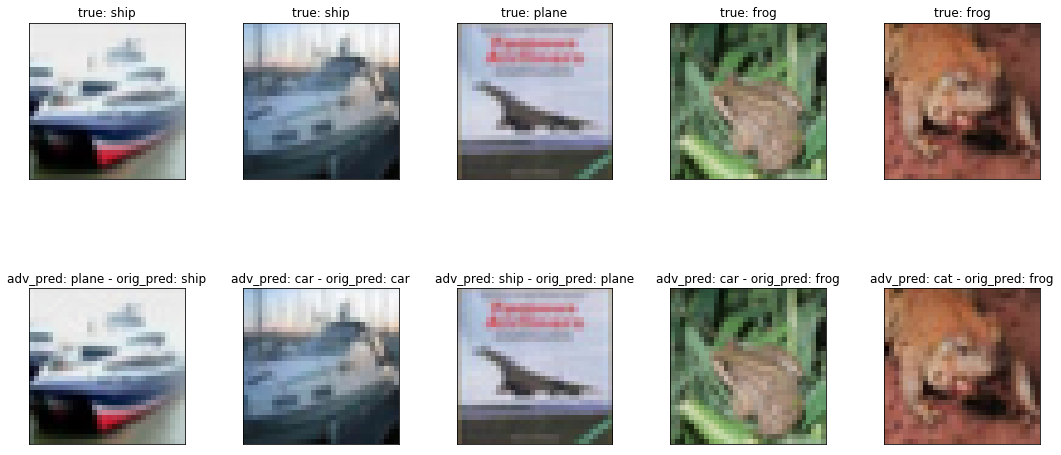

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


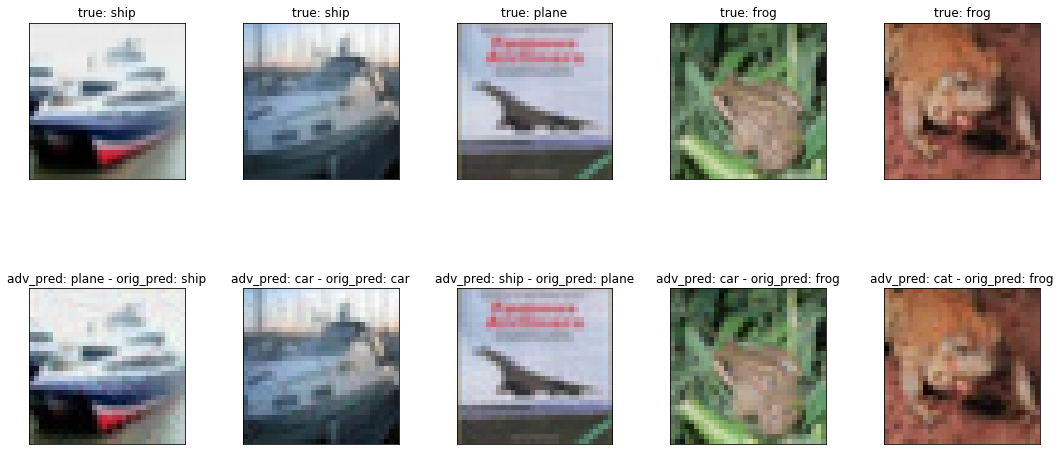

Perturbed Accuracy: 66/100 (66%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


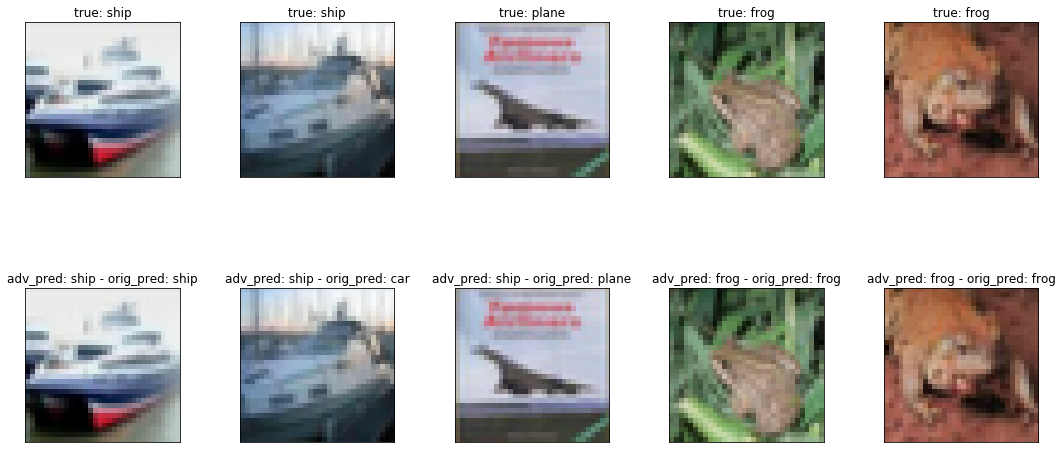

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


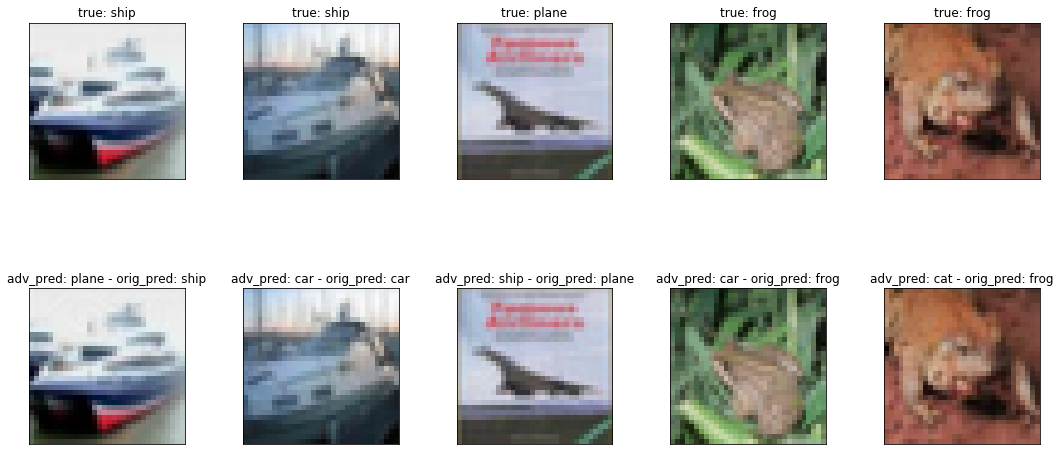

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


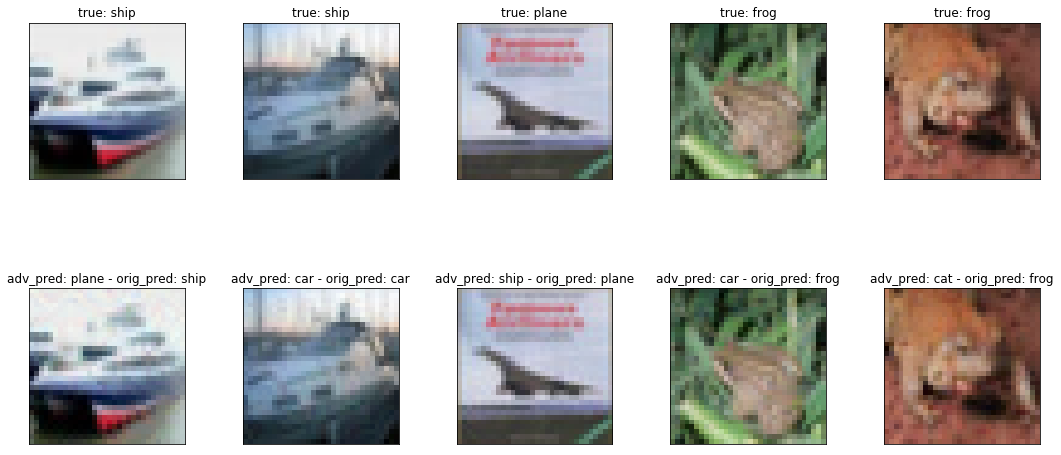

Perturbed Accuracy: 63/100 (63%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


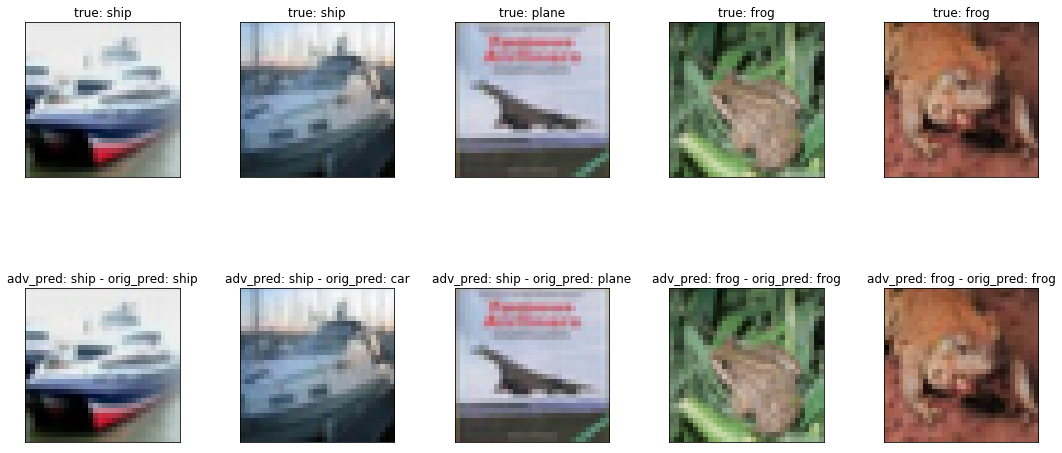

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


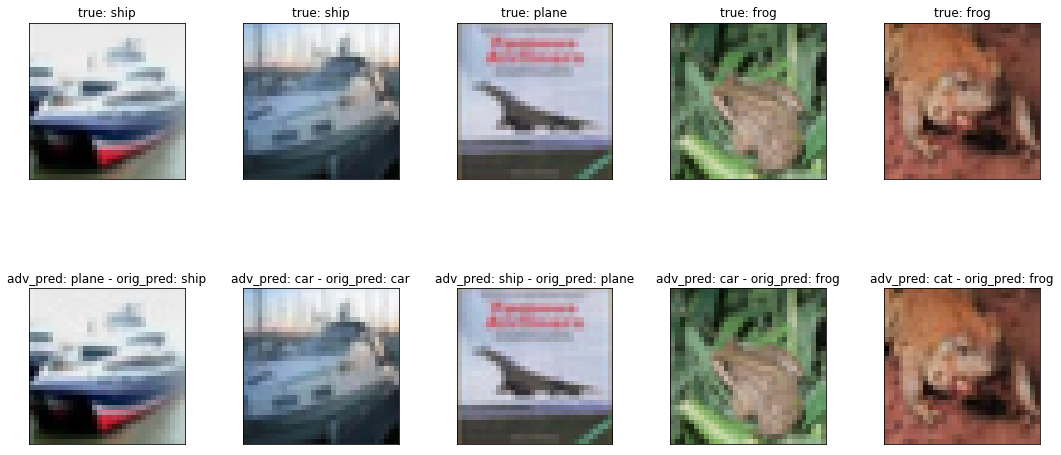

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


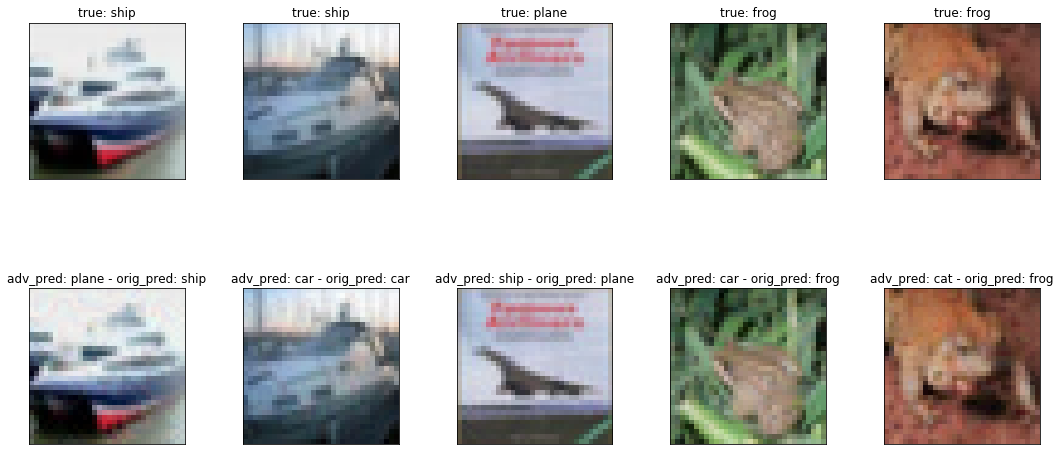

Perturbed Accuracy: 60/100 (60%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


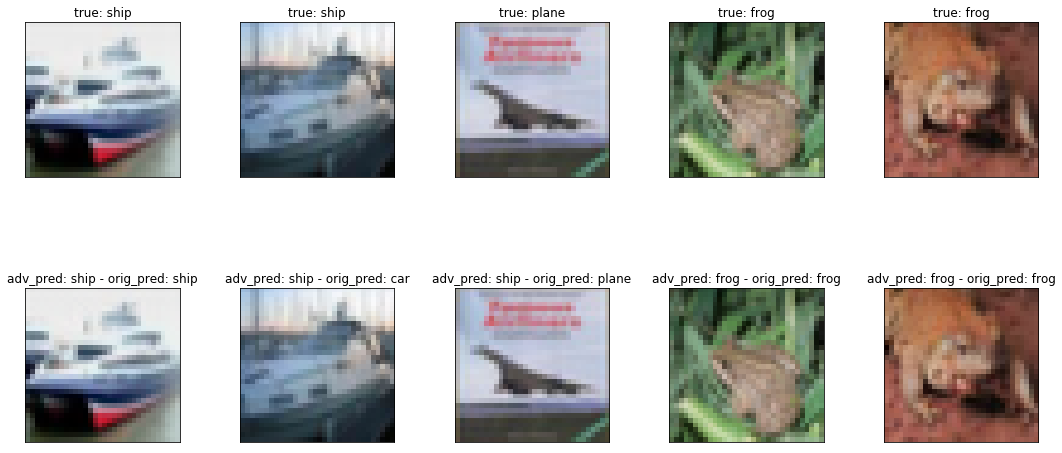

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


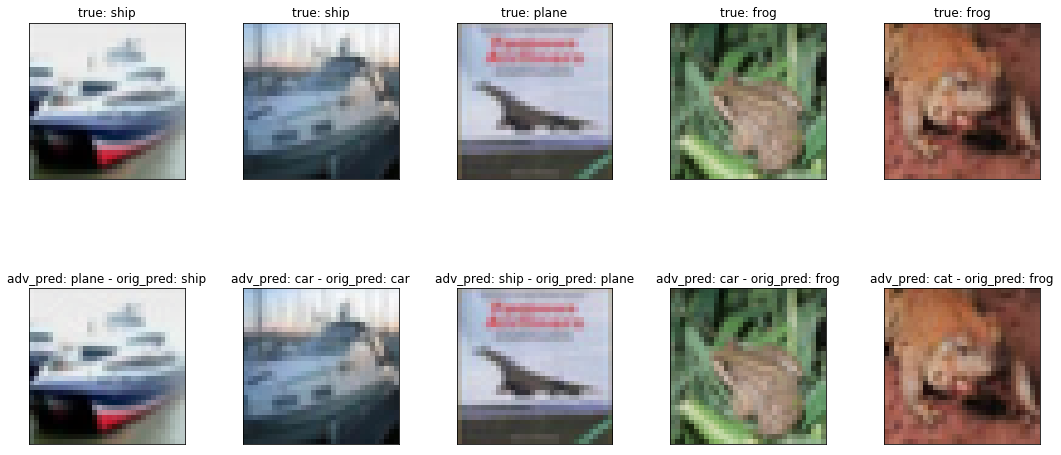

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


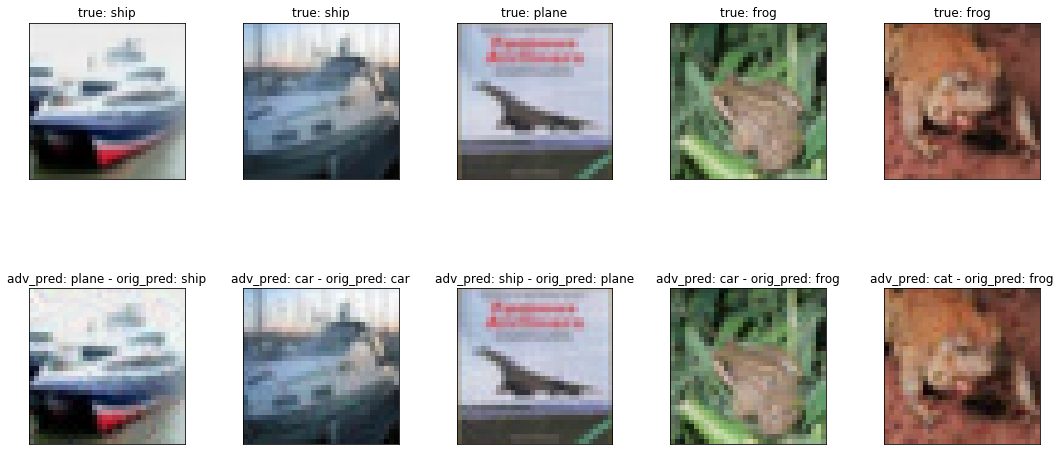

Perturbed Accuracy: 56/100 (56%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


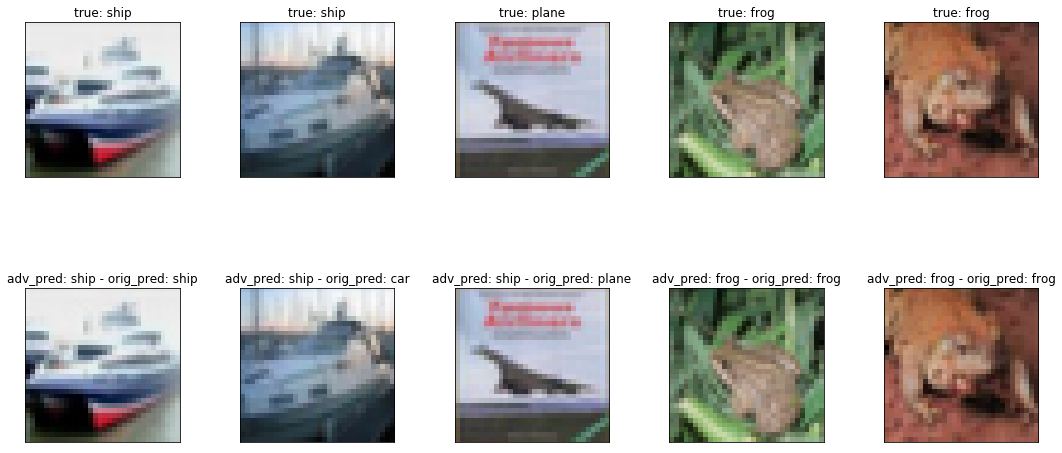

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


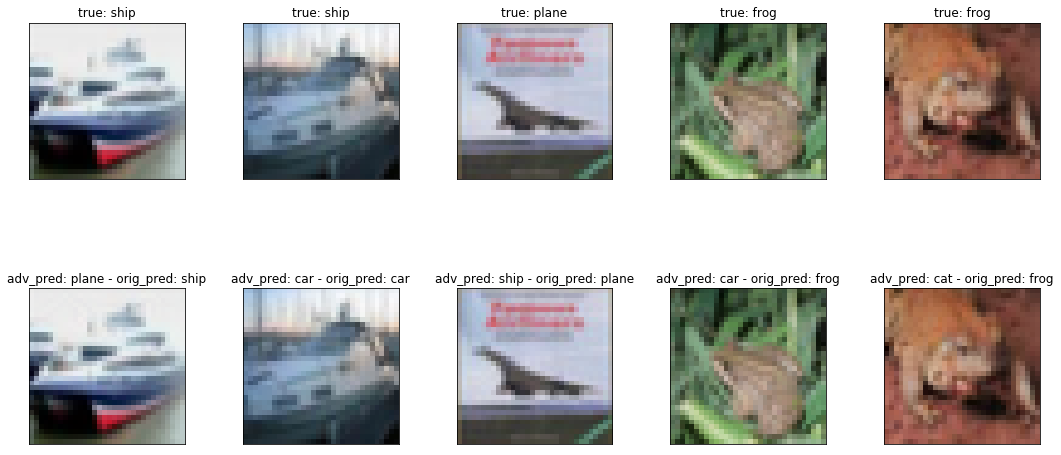

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


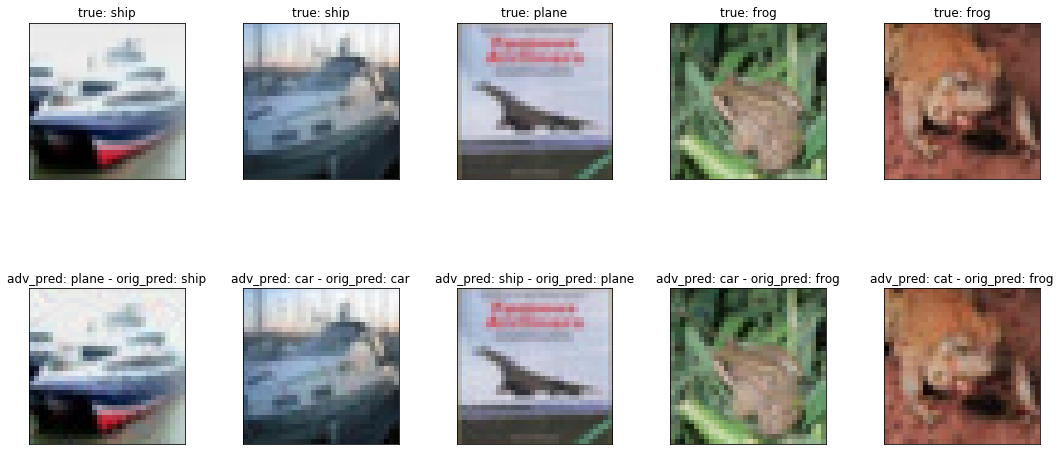

Perturbed Accuracy: 59/100 (59%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


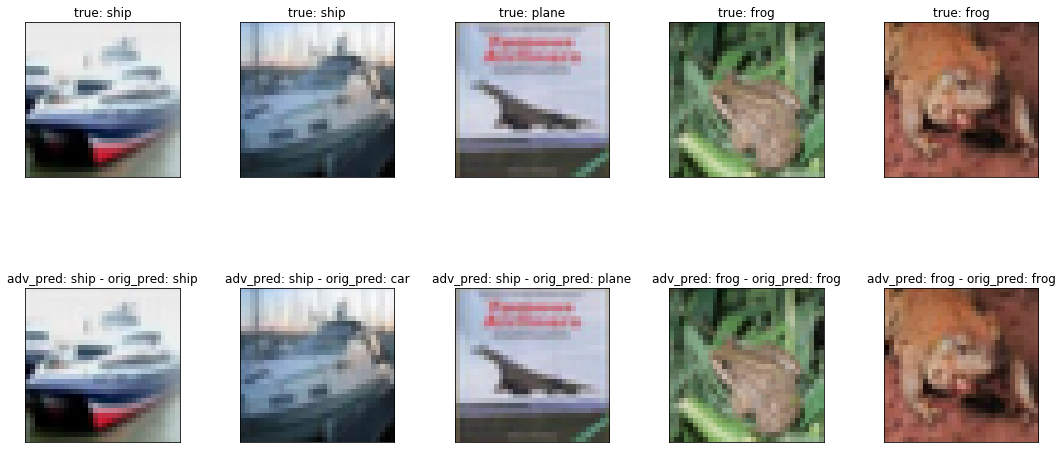

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


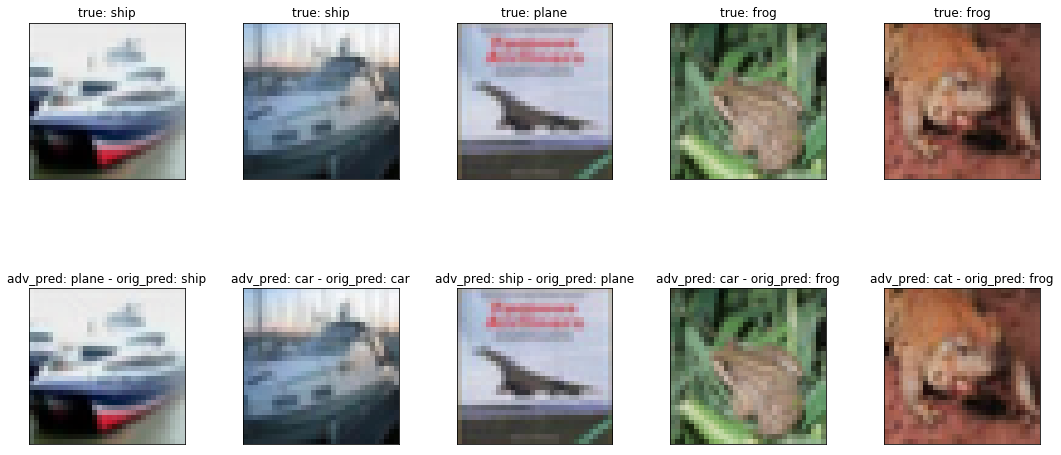

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


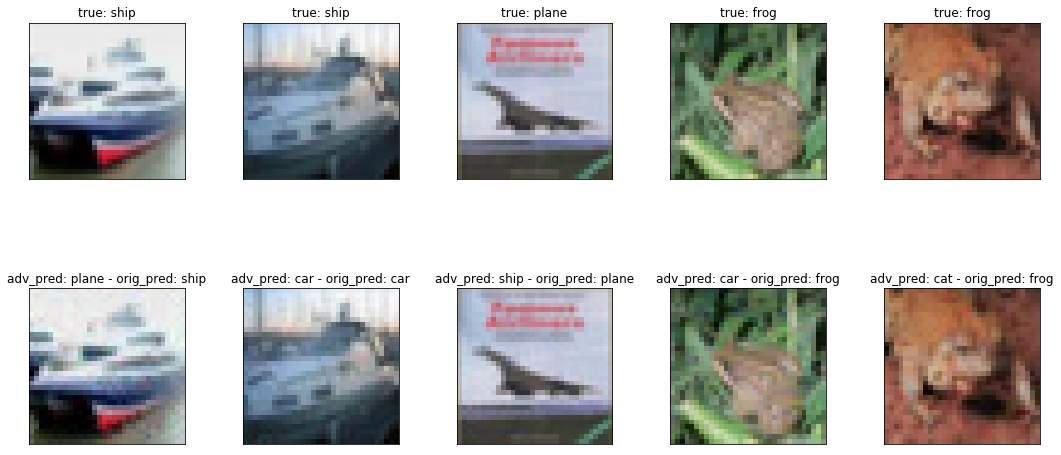

Perturbed Accuracy: 61/100 (61%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


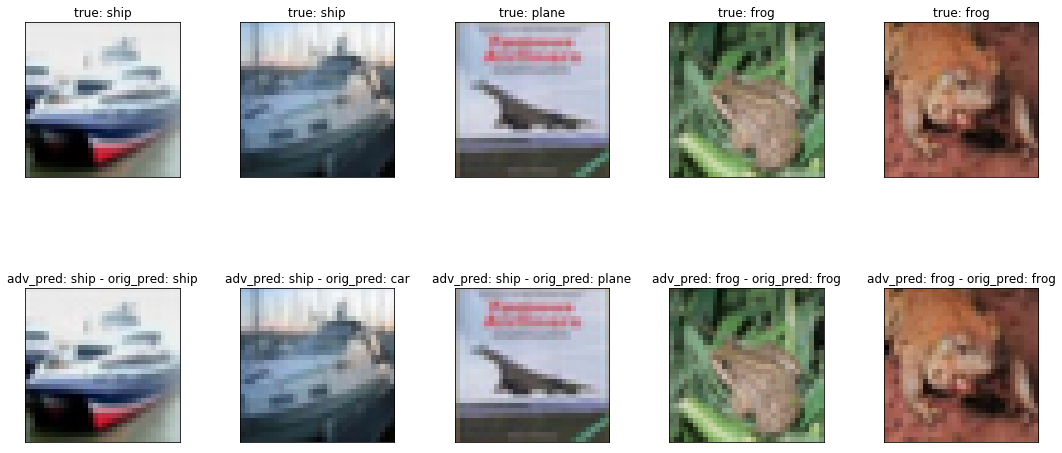

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


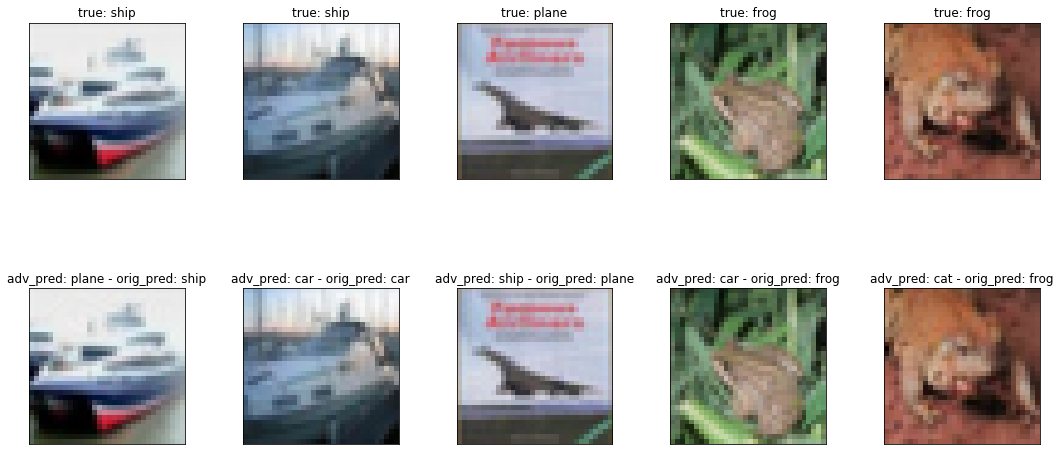

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


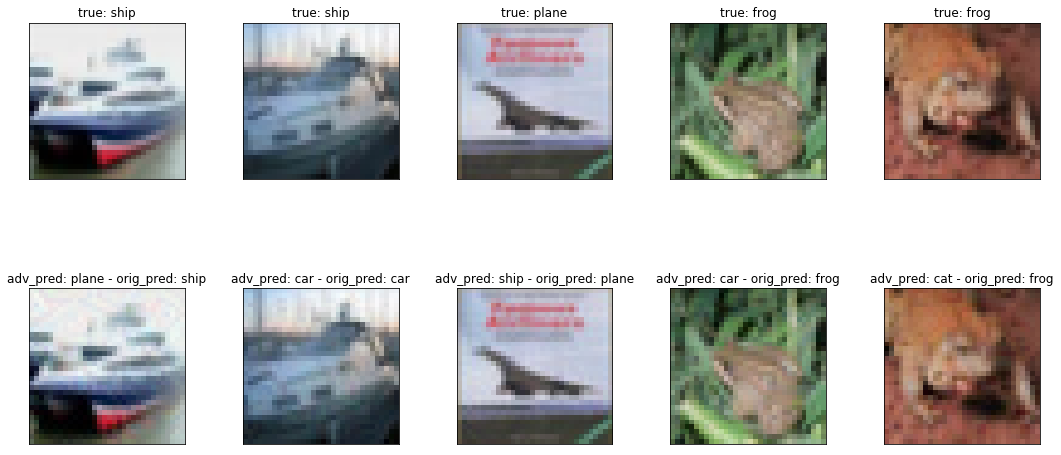

Perturbed Accuracy: 64/100 (64%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


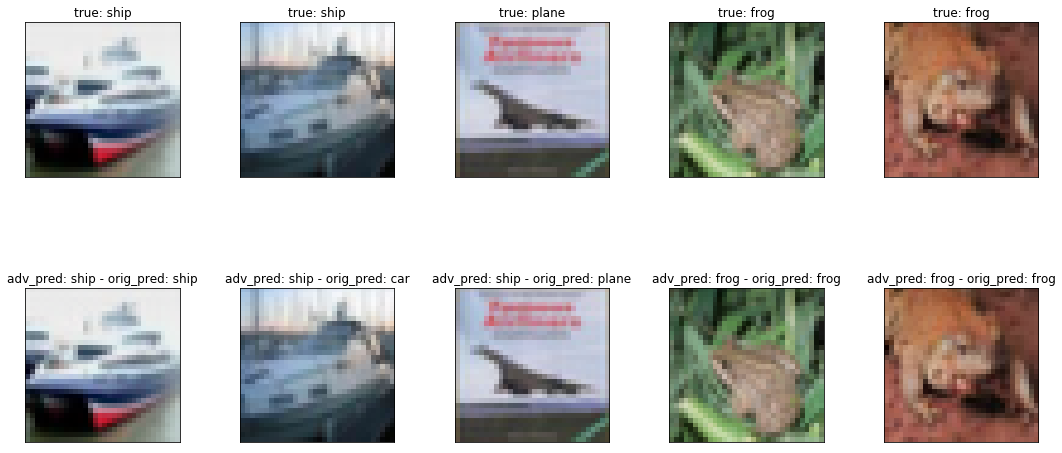

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


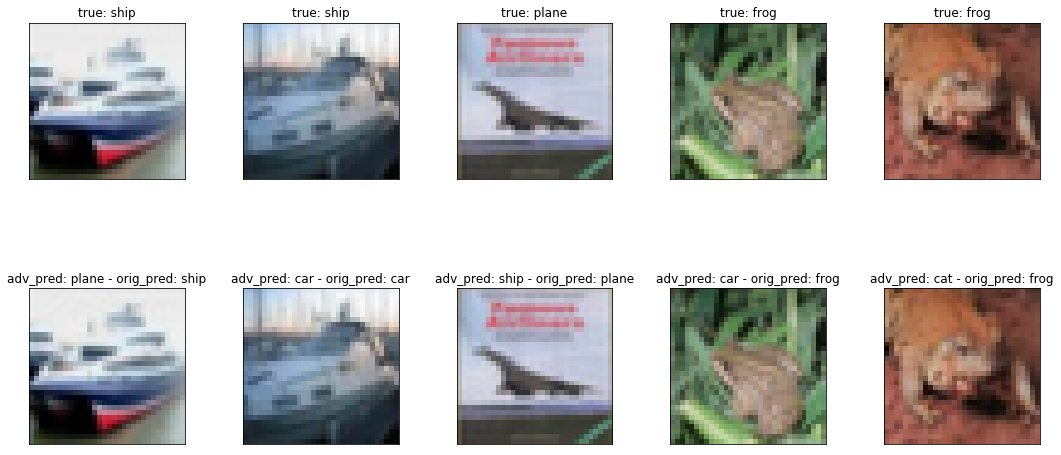

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


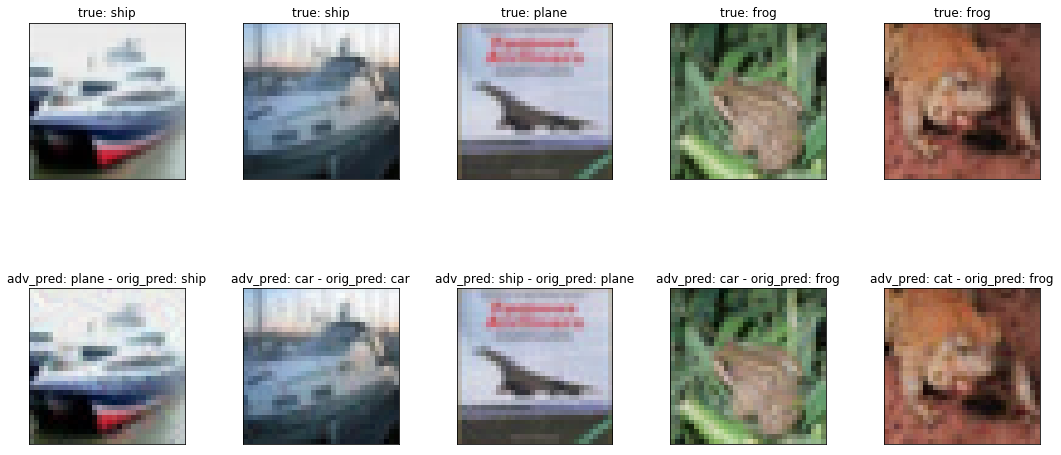

Perturbed Accuracy: 55/100 (55%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


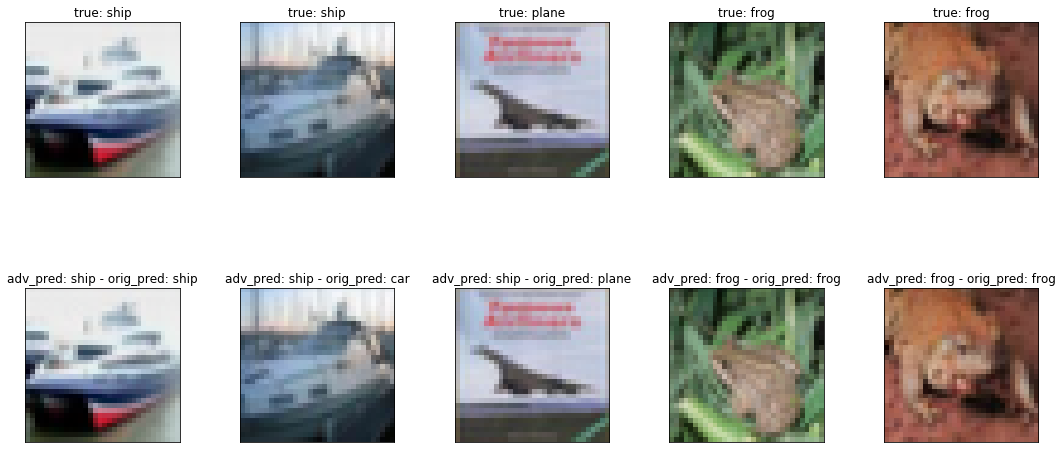

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


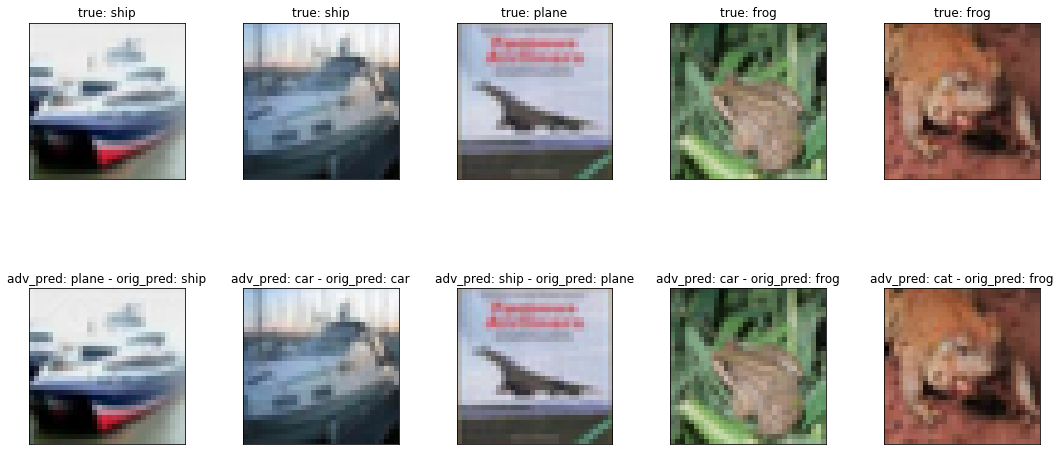

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


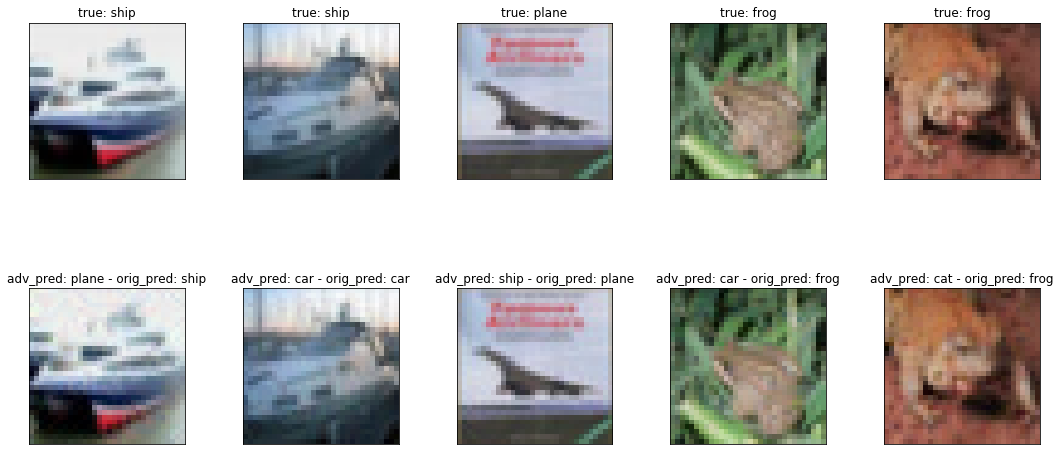

Perturbed Accuracy: 63/100 (63%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


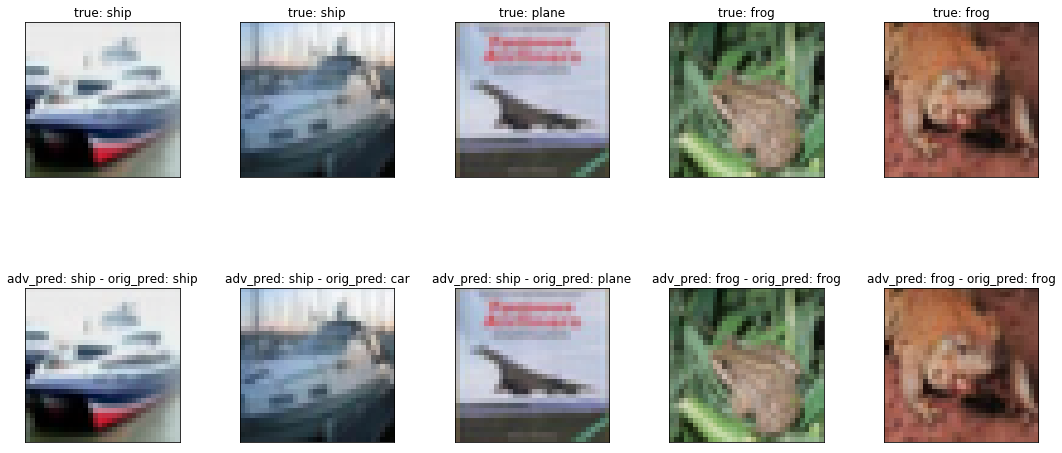

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


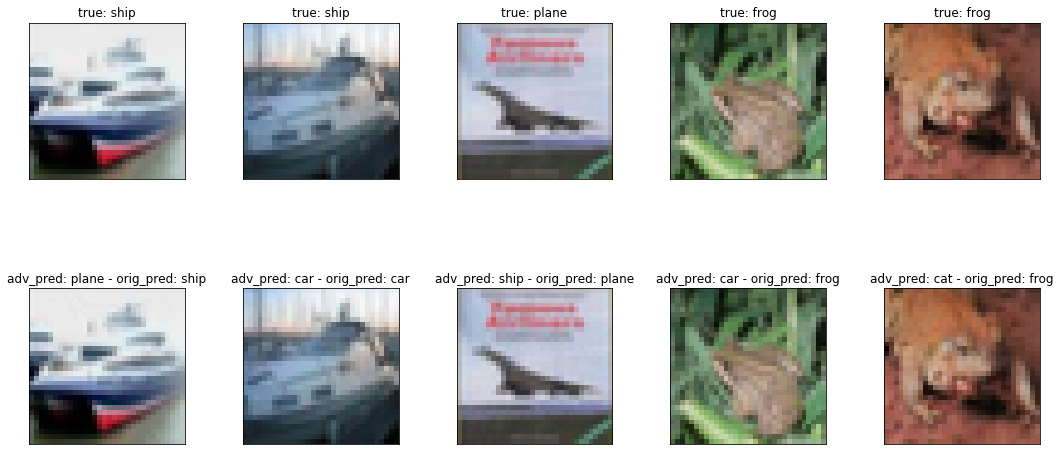

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


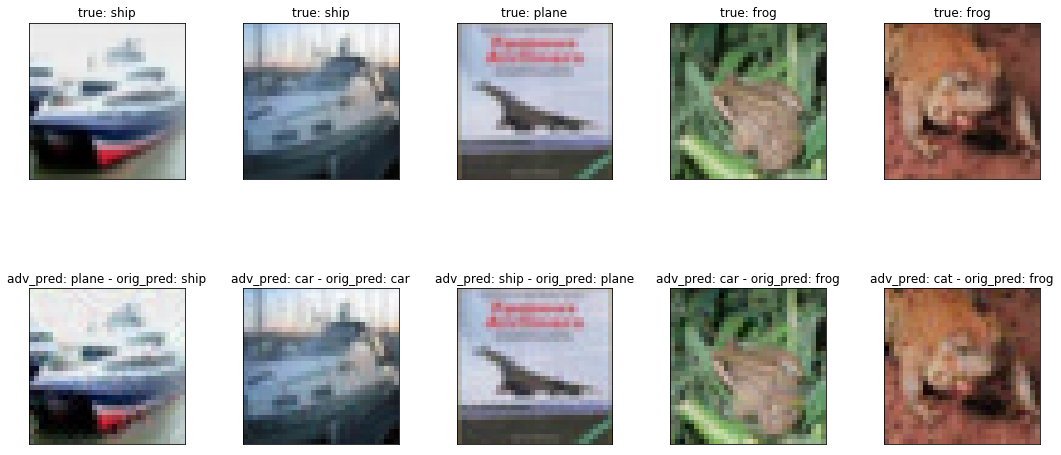

Perturbed Accuracy: 63/100 (63%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


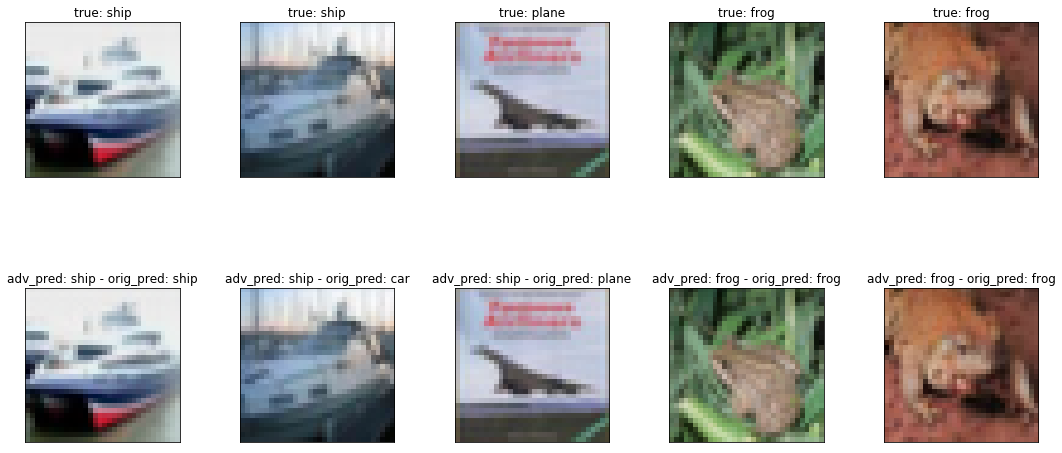

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


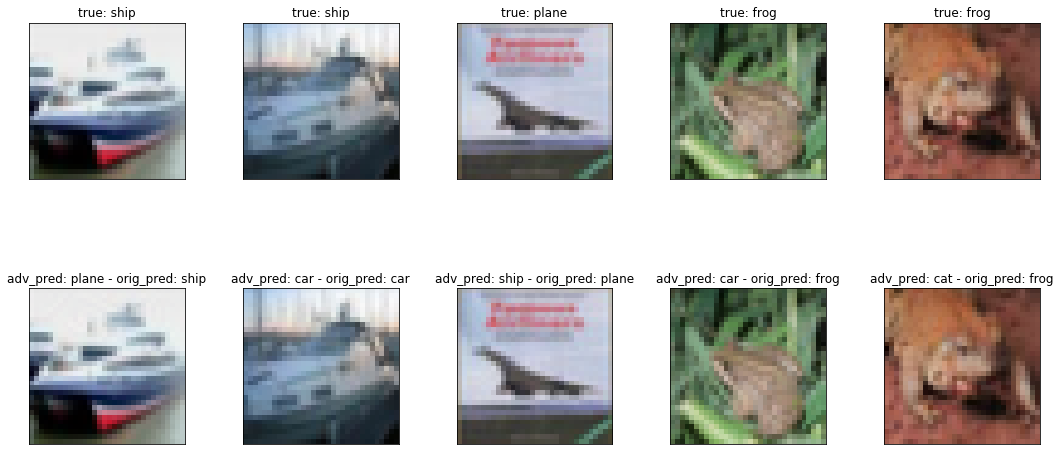

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


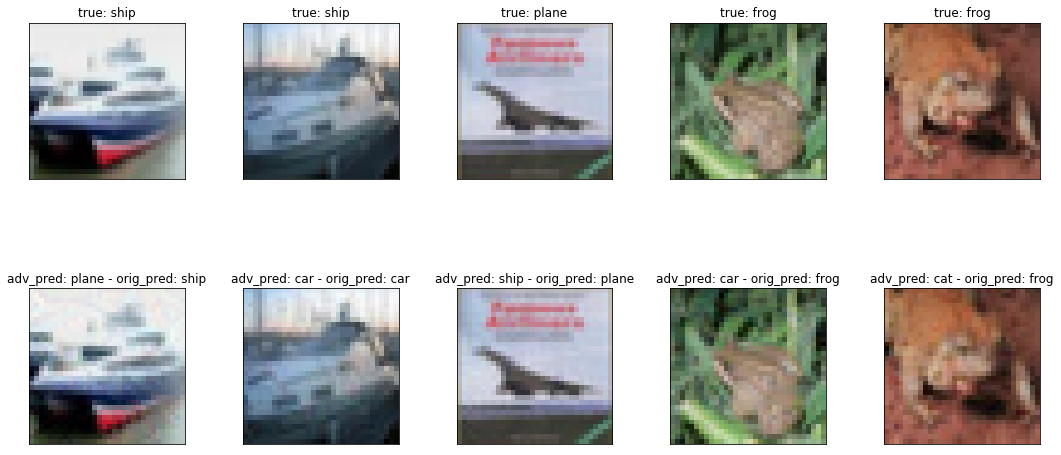

Perturbed Accuracy: 62/100 (62%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


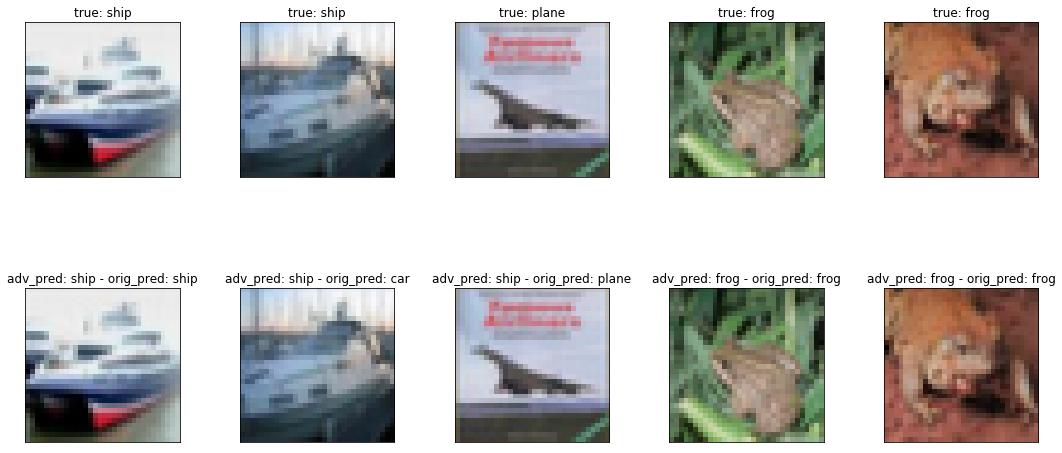

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


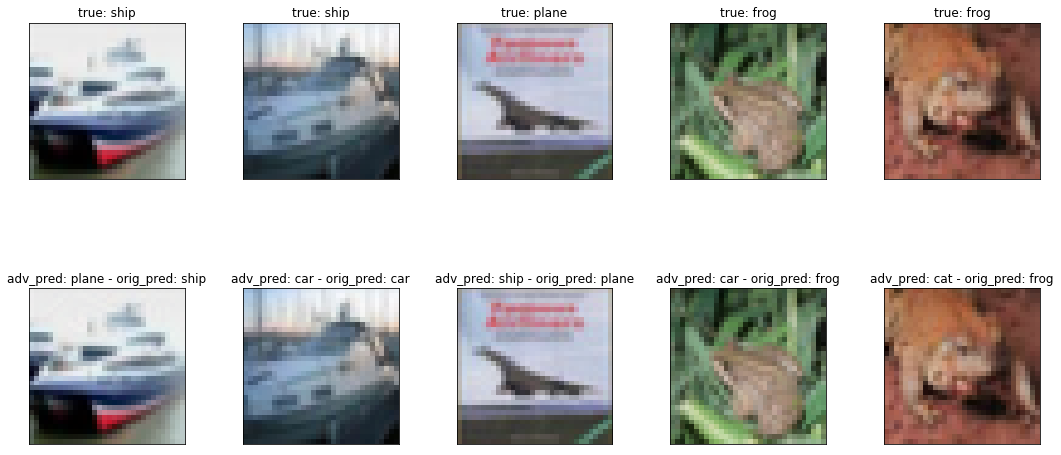

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


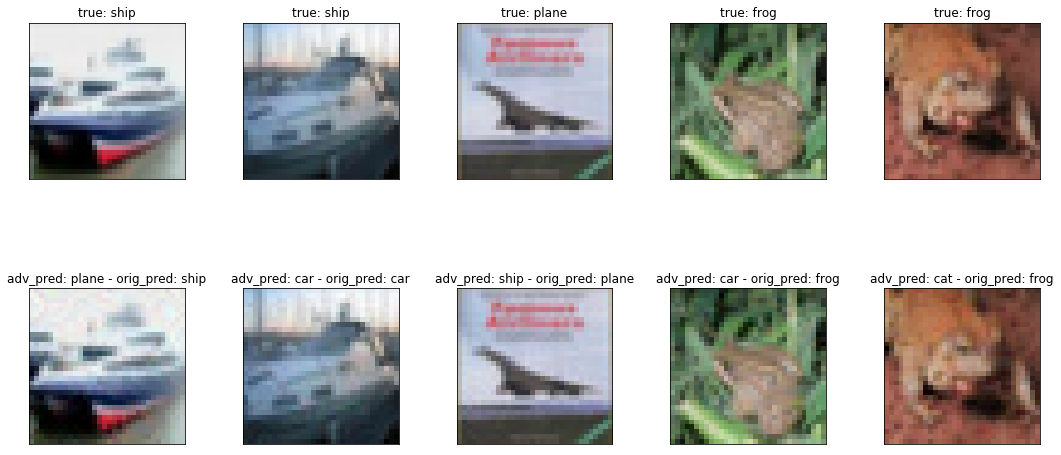

Perturbed Accuracy: 68/100 (68%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


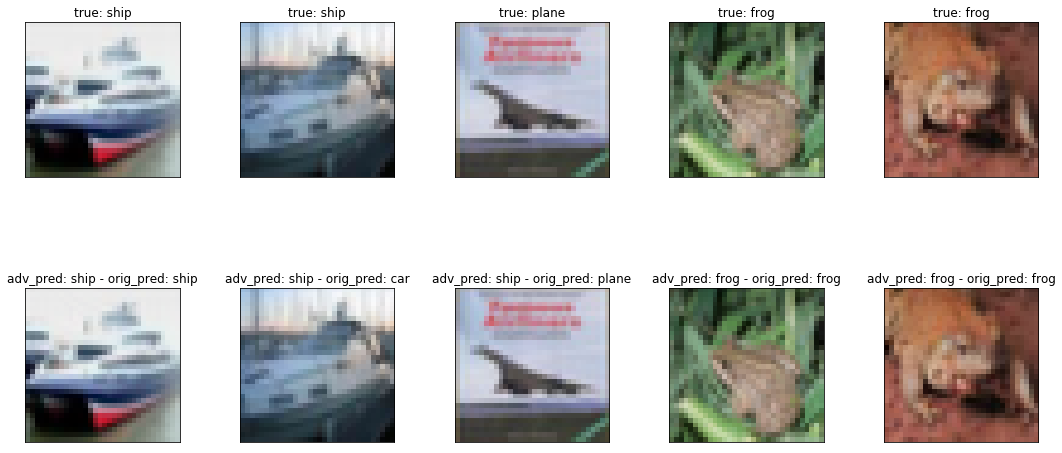

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


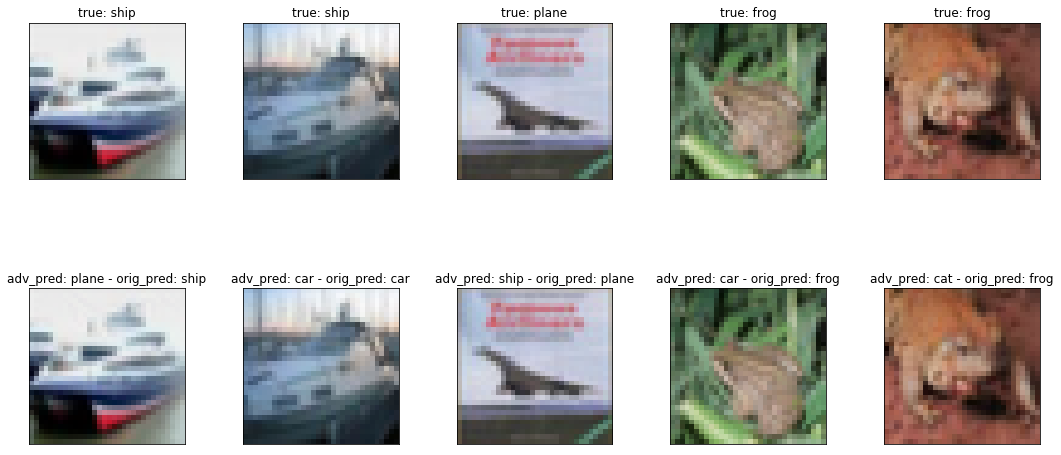

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


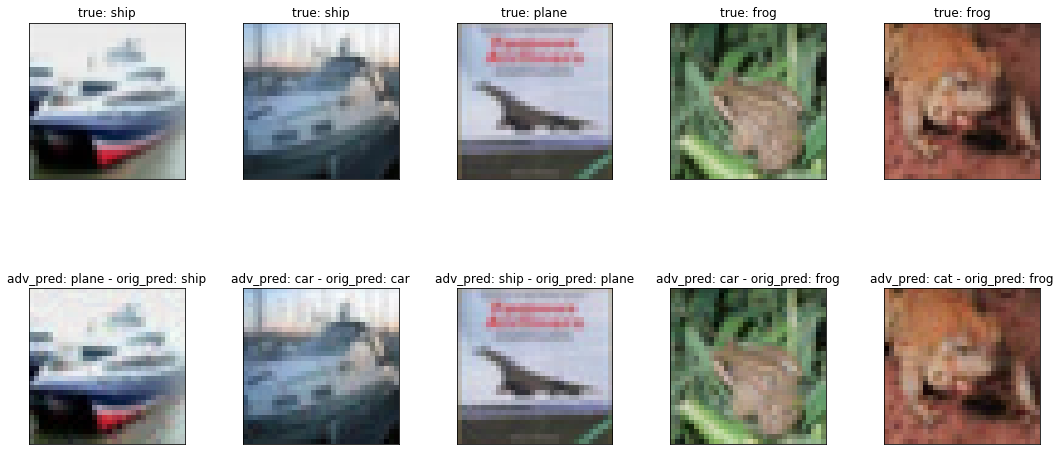

Perturbed Accuracy: 67/100 (67%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


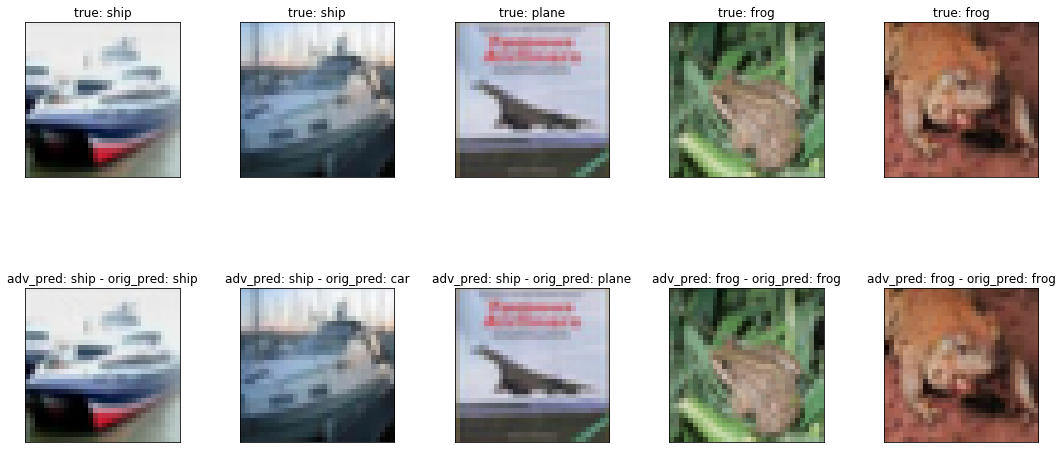

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


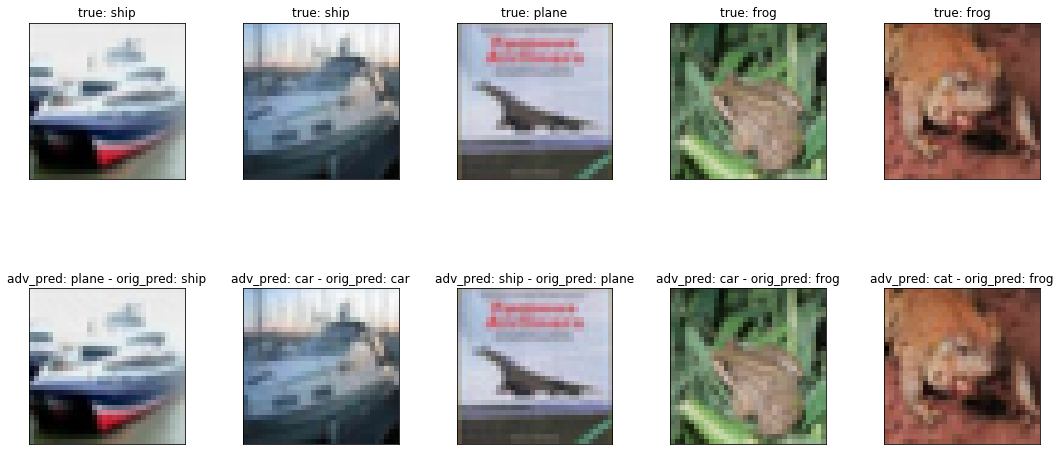

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


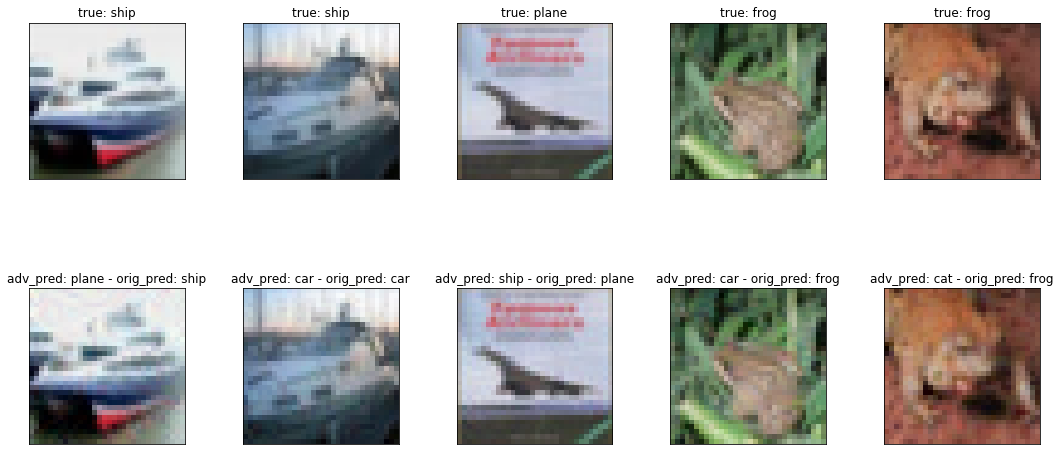

Perturbed Accuracy: 64/100 (64%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


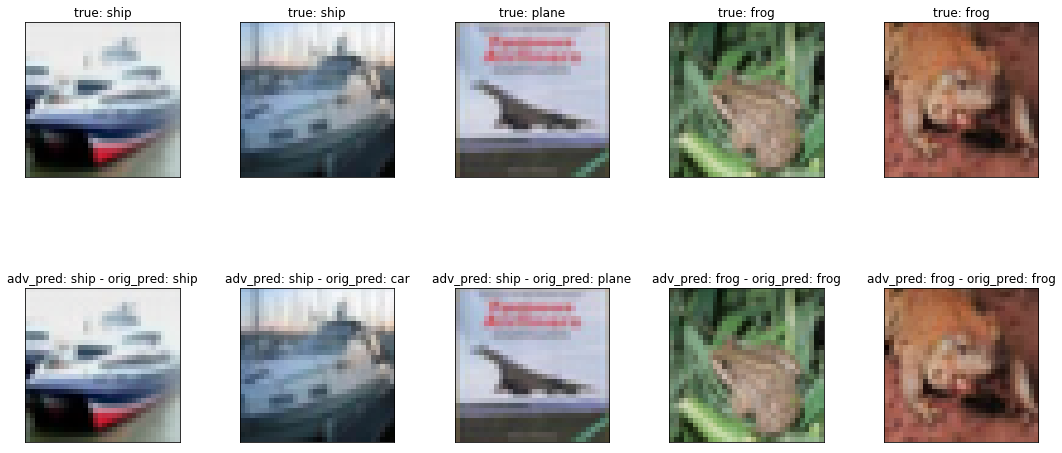

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


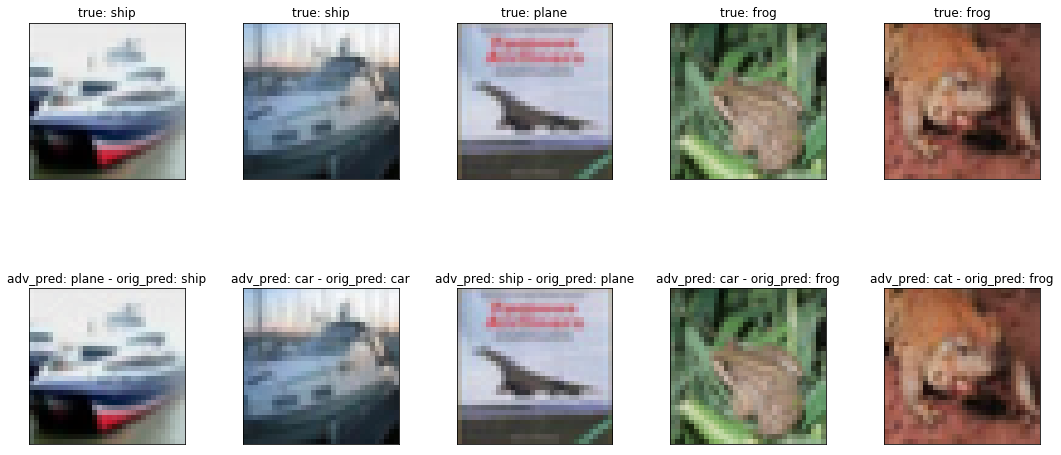

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


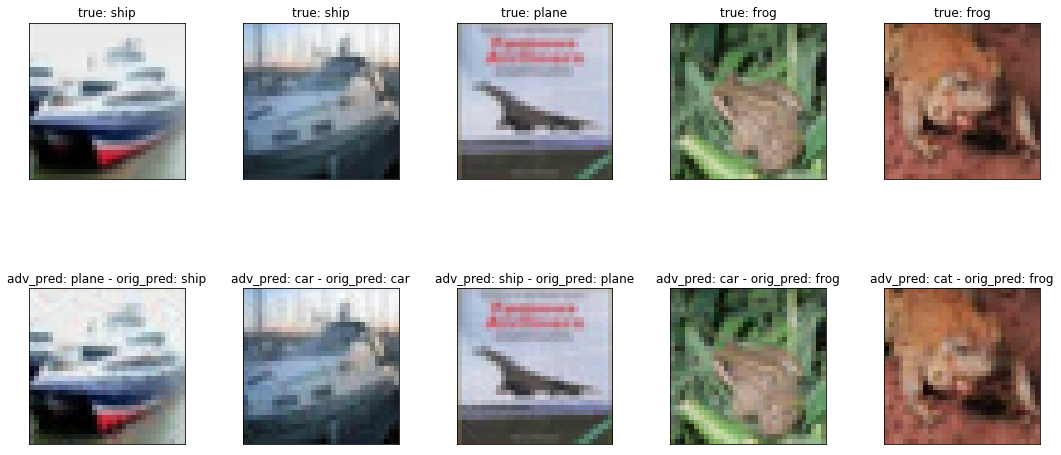

Perturbed Accuracy: 62/100 (62%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


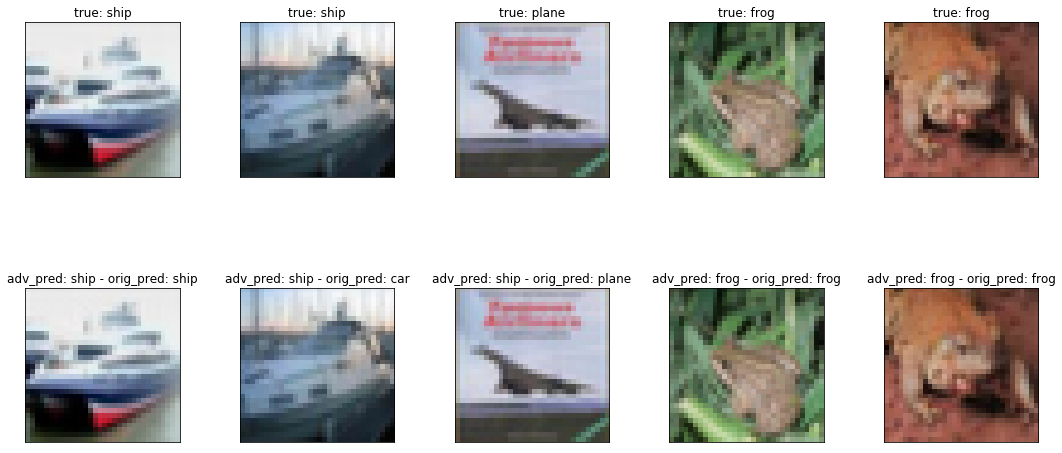

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


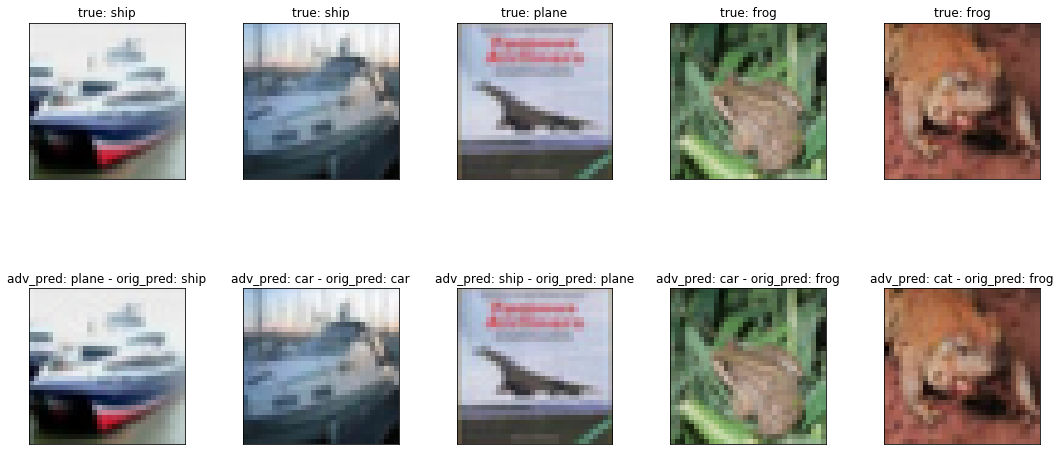

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


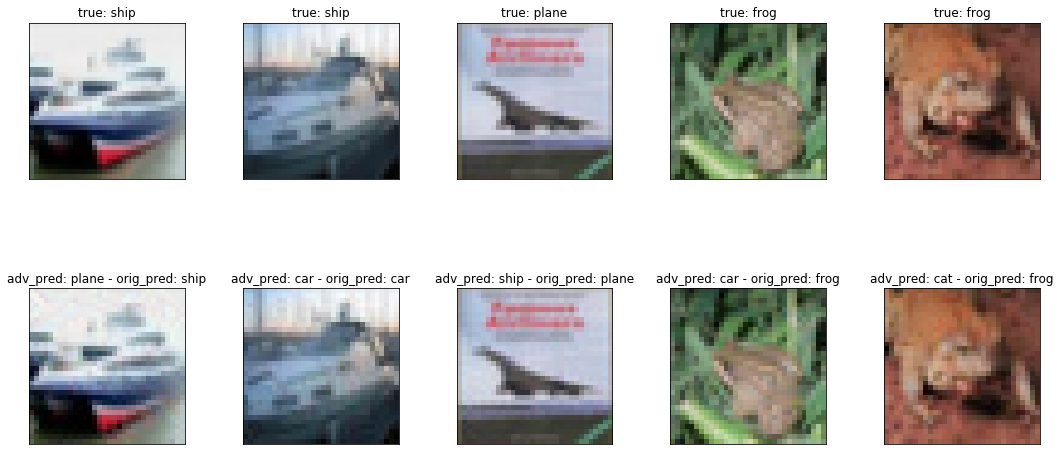

Perturbed Accuracy: 61/100 (61%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


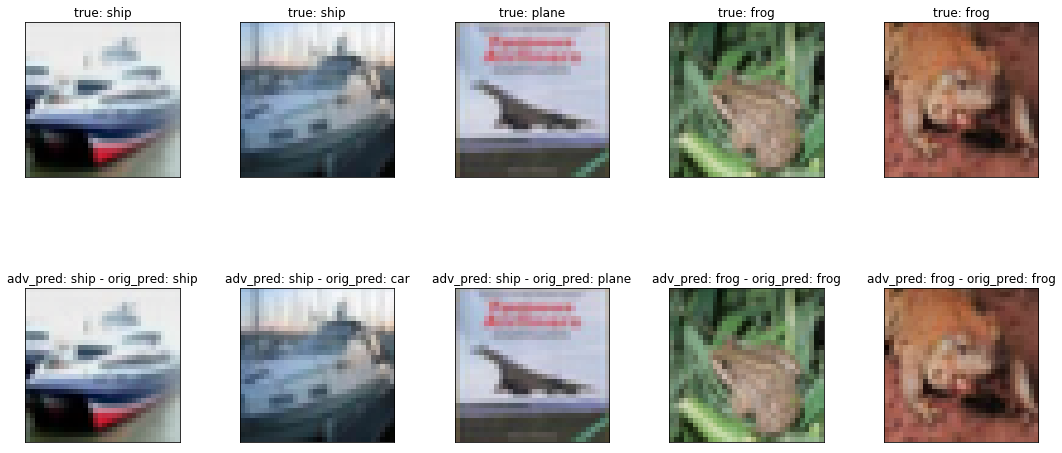

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


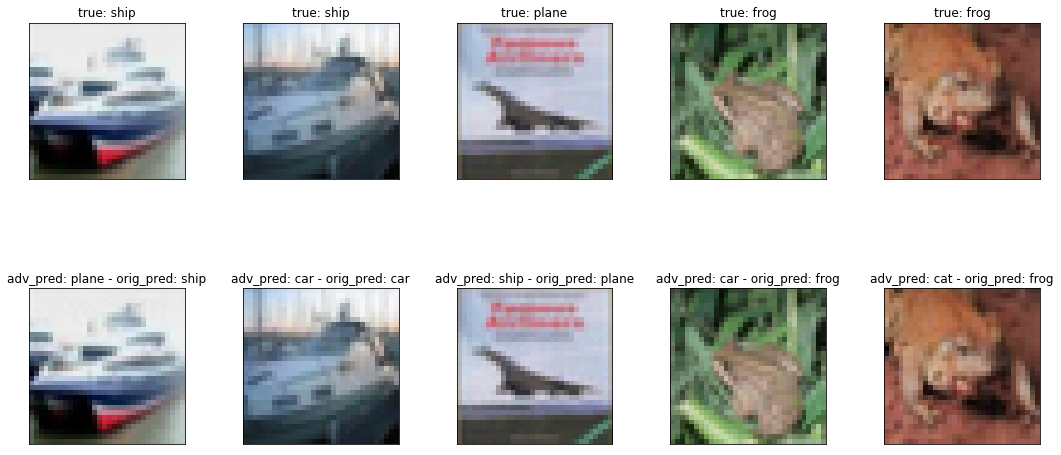

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


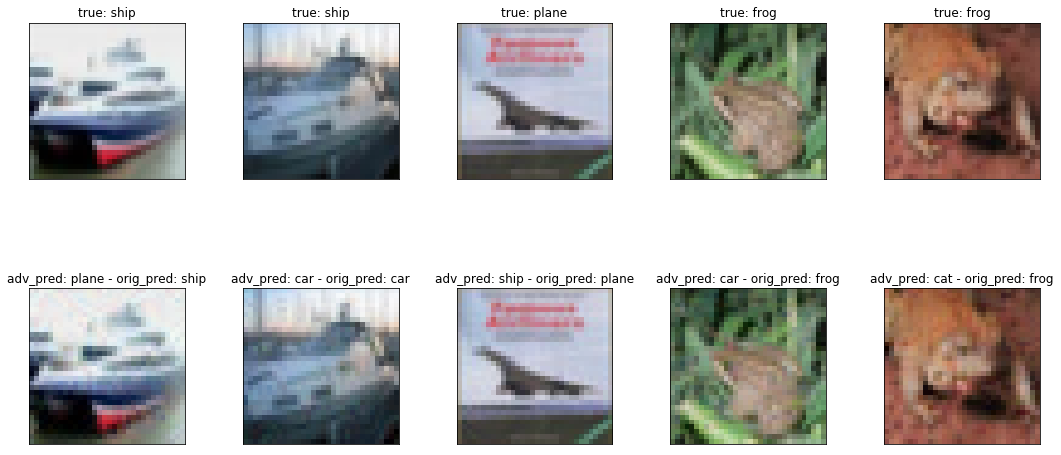

Perturbed Accuracy: 51/100 (51%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


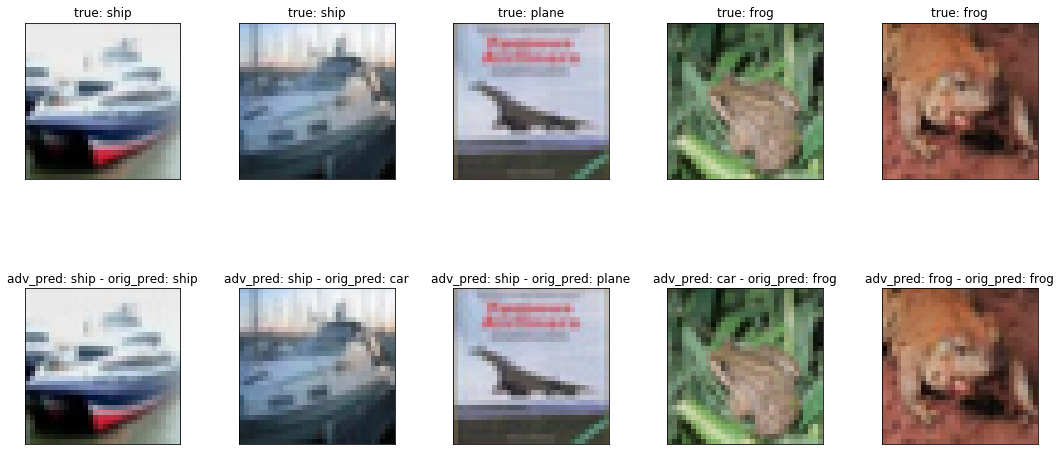

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


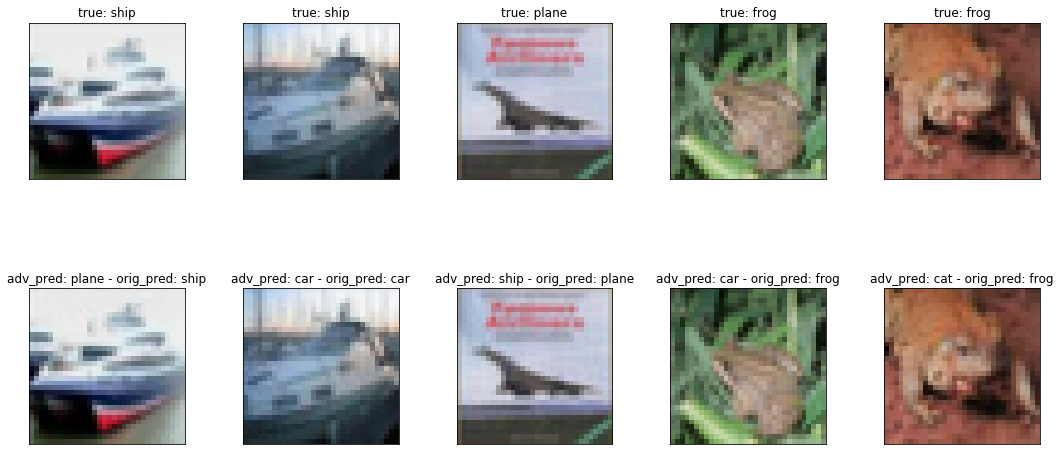

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


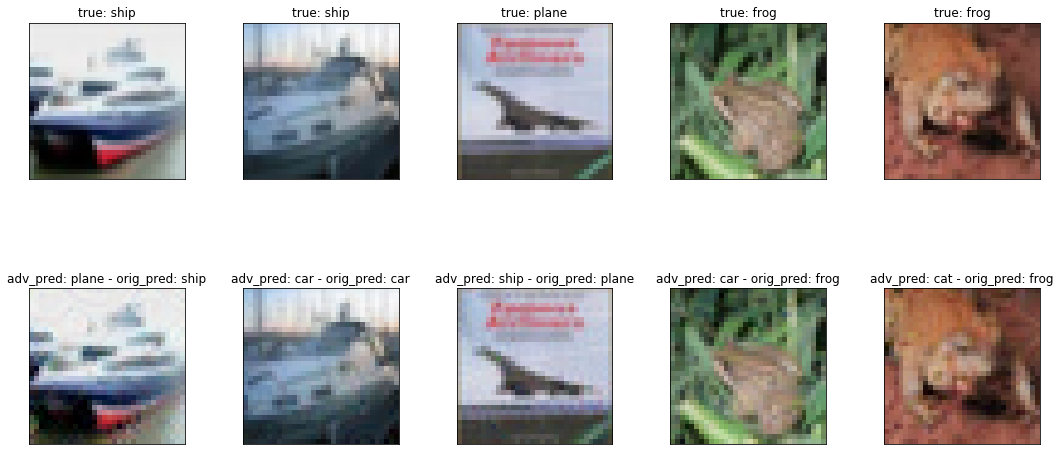

Perturbed Accuracy: 60/100 (60%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


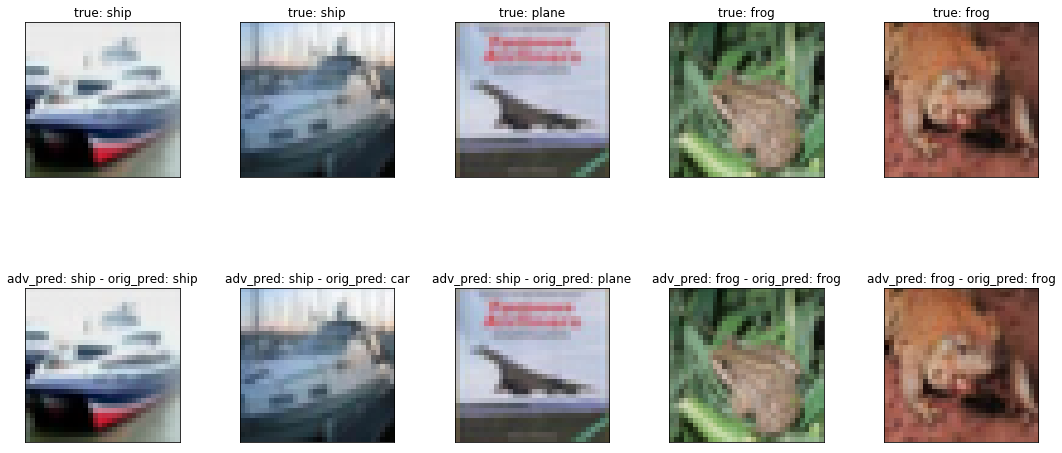

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


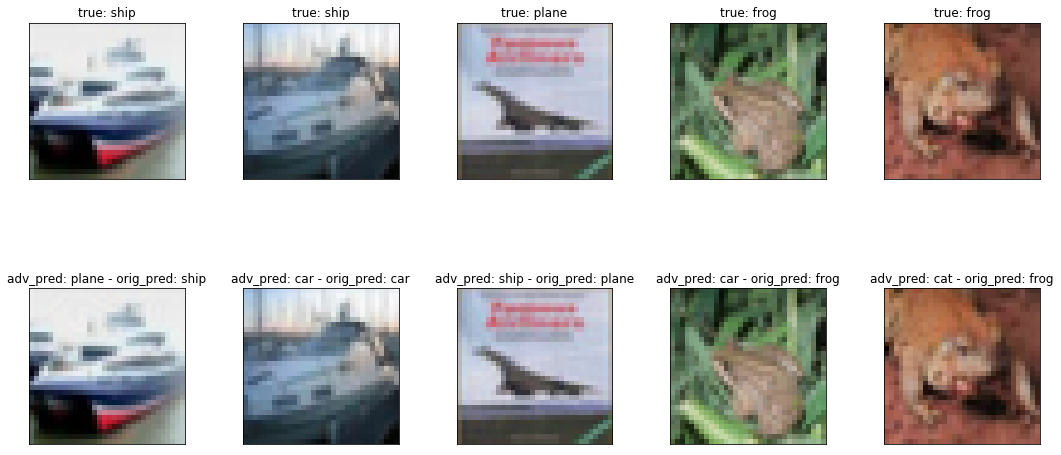

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


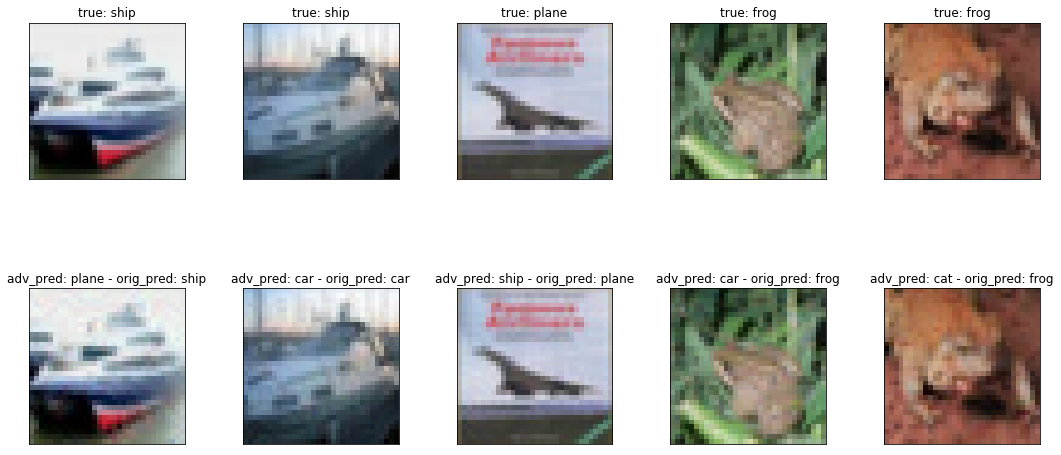

Perturbed Accuracy: 74/100 (74%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


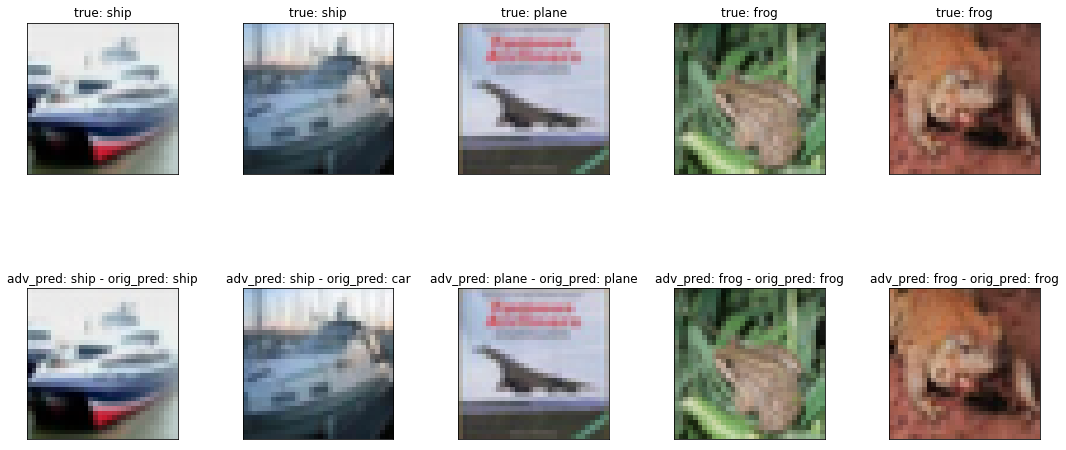

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


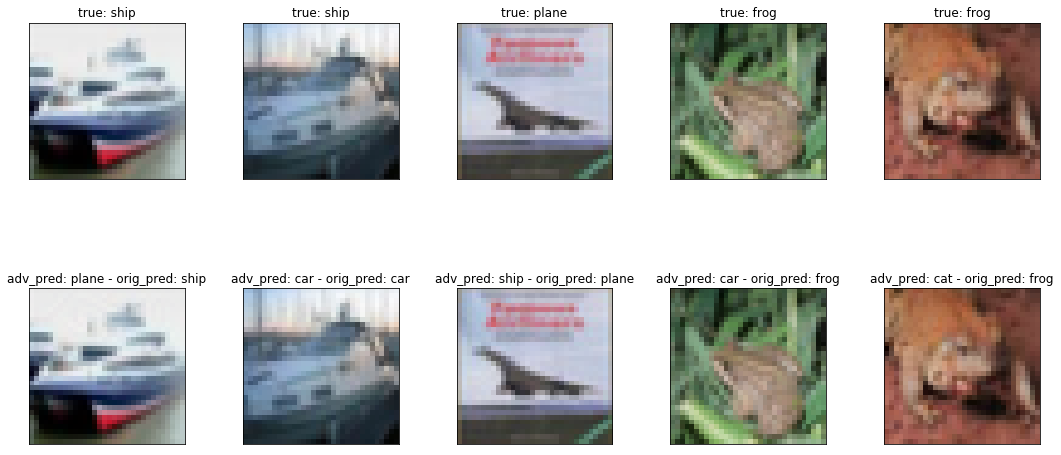

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


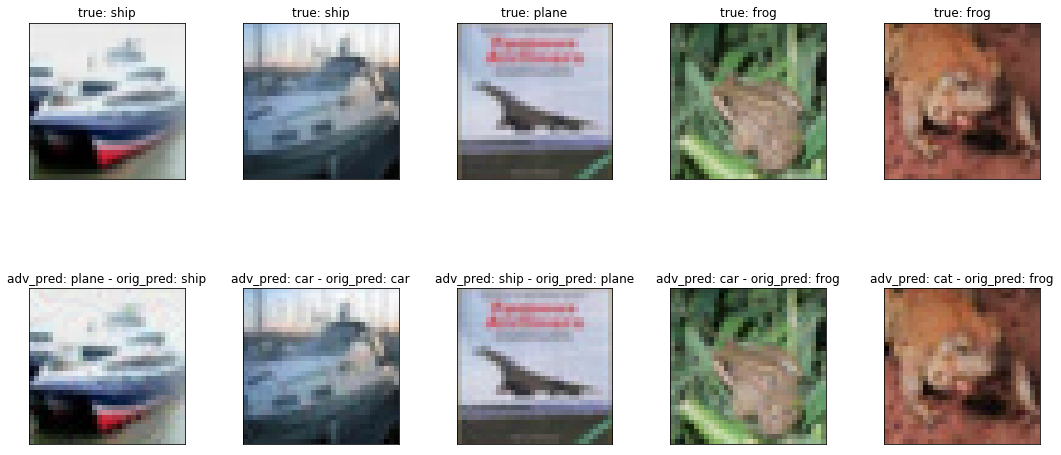

Perturbed Accuracy: 67/100 (67%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


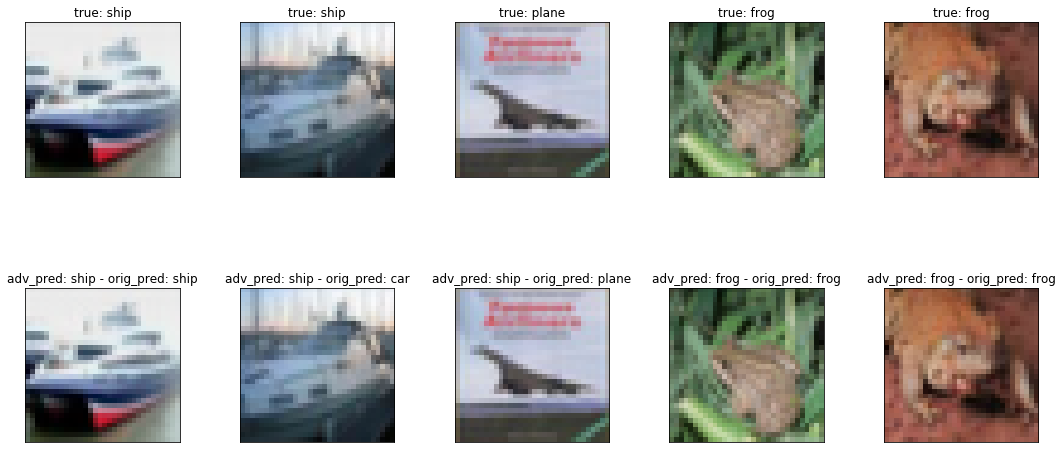

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


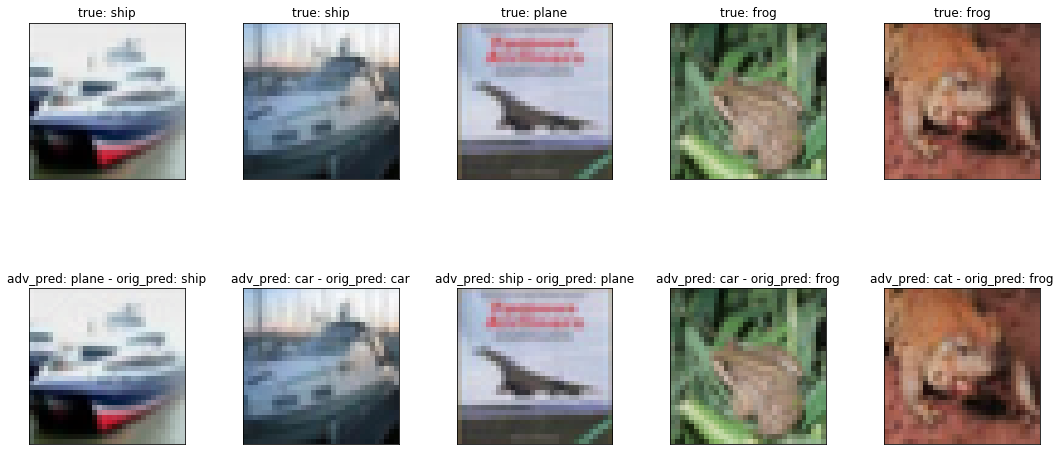

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


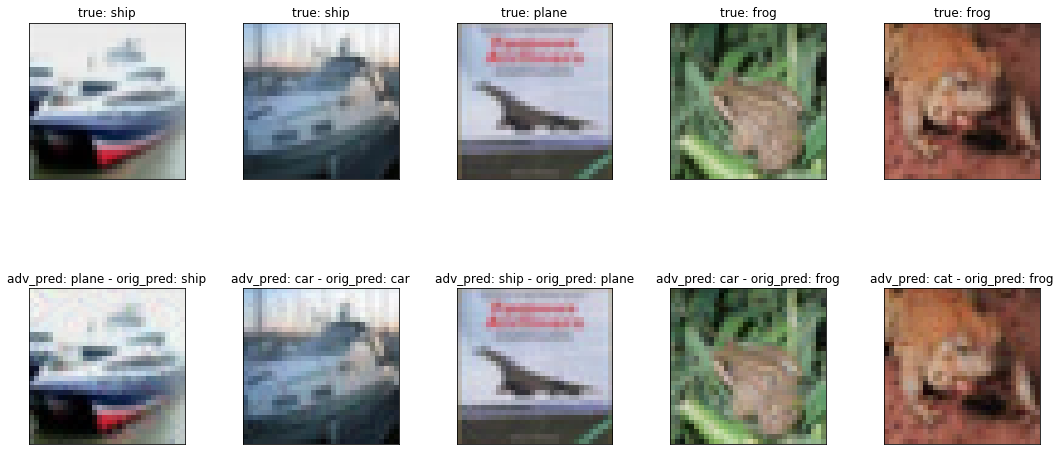

Perturbed Accuracy: 63/100 (63%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


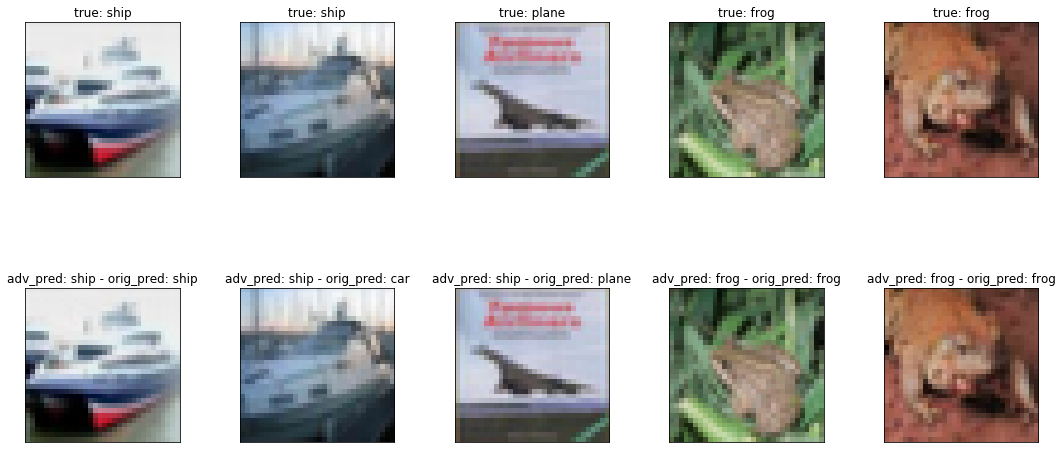

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


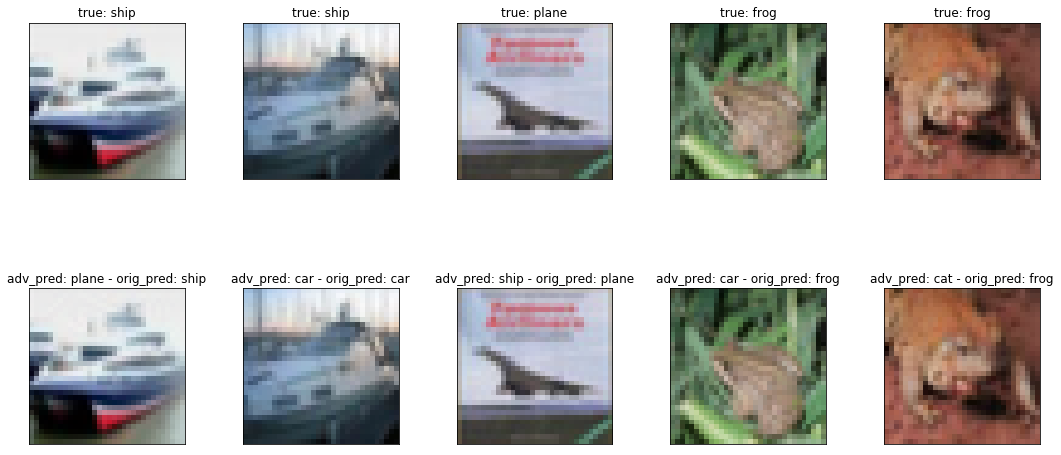

Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


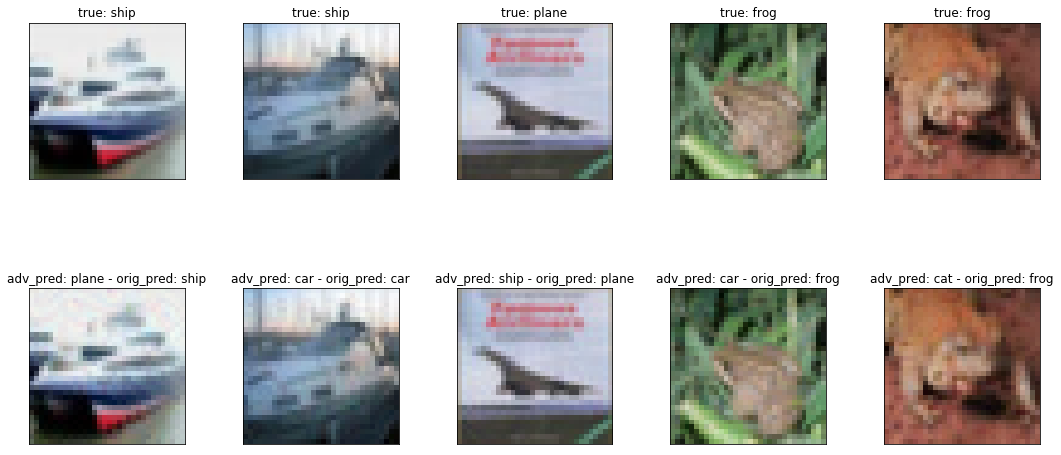

In [76]:
for result in results:
    pert_acc, orig_acc = eval_performance(model, inputs, result['adversaries'], targets)
    sample_3D_images(model, inputs, result['adversaries'], targets, classes)

In [87]:
for i, result in enumerate(results):
    pert_norms = torch.pow(result['adversaries'] - inputs, exponent=2)
    pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1).mean().item()
    result['mean_l2_distance_from_inputs'] = pert_norms
    print(i, '\t', pert_norms, '\t', result['pert_acc'])
    
pickle.dump(results, open("assets/results_cifar10_2019.08.14.pickle", "wb"))

0 	 0.007156517822295427 	 0.62
1 	 0.04534241184592247 	 0.0
2 	 0.9647254943847656 	 0.0
3 	 0.007746806368231773 	 0.69
4 	 0.046000584959983826 	 0.0
5 	 0.9833644032478333 	 0.0
6 	 0.007739795371890068 	 0.68
7 	 0.04622668772935867 	 0.0
8 	 0.9286143183708191 	 0.0
9 	 0.008712038397789001 	 0.66
10 	 0.04844072088599205 	 0.0
11 	 0.9611809849739075 	 0.0
12 	 0.0071218120865523815 	 0.63
13 	 0.04556626081466675 	 0.0
14 	 0.8572835922241211 	 0.0
15 	 0.007239618804305792 	 0.6
16 	 0.0461786724627018 	 0.0
17 	 1.028593897819519 	 0.0
18 	 0.0076391915790736675 	 0.56
19 	 0.04636650159955025 	 0.0
20 	 0.929305374622345 	 0.0
21 	 0.010969972237944603 	 0.59
22 	 0.05438665300607681 	 0.0
23 	 1.1025364398956299 	 0.0
24 	 0.007194219157099724 	 0.61
25 	 0.045786693692207336 	 0.0
26 	 1.0369354486465454 	 0.0
27 	 0.007500585168600082 	 0.64
28 	 0.045592982321977615 	 0.0
29 	 0.9898582100868225 	 0.0
30 	 0.008851232007145882 	 0.55
31 	 0.04900619015097618 	 0.0
32 	 